[#air-polution-sensor](https://github.com/Johansmm/air-polution-sensor)

 # Spatial and temporal analysis of signals to detect drift of air quality sensors
 
The network of sensors allows to follow a complex phenomenon by observing the temporal evolution of the values in several points, and by crossing the information from one sensor to another. This allows, for example, to carry out a meteorological or seismic monitoring, by detecting a cloud or a tremor. However, the sensors used are sometimes subject to drift, wear and tear or possible interference, which makes some of the observed values false. It is therefore important to be able to determine if a sensor starts to drift in order to allow a good analysis of the data. Therefore, the objective of this project is to detect a drifting sensor (when and where) in a real sensor's network. For this, we will explore the usefulness of a particular mathematical tool: the graph space-time spectrogram. Such a tool allows to decompose a space-time series into a sum of space-time frequencies, in a similar way to Fourier analysis, but for signals in graphs.

In [2]:
# Libraries
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Basis libraries 
import sys, getpass, os, copy
import numpy as np
import scipy.signal
from matplotlib import rc
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import scipy.signal
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from statistics import mean 
from IPython.display import Image
from google.colab import files

# Library for boxplots
# font = {'family':'sans-serif','sans-serif':['Helvetica'], 'size':18}
# rc('font', **font)
# rc('text', usetex=True)

np.random.seed(1)

In [4]:
# Colab access
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

# If you work-directory don't match, please add the new path to pwd_list
cwd_list = ["/content/gdrive/My Drive/S5 Project: Air polution/air-polution-sensor/",
            "/content/gdrive/My Drive/Colab Notebooks/ProyectS5/air-polution-sensor/",
            "/content/gdrive/MyDrive/IMT Atlantique/Project_S5_Air/air-polution-sensor/",
            os.path.join(os.getcwd(),"air-polution-sensor")]

for cwd in cwd_list:
    if os.path.isdir(cwd):
        %cd "$cwd"
        break
if os.path.split(os.getcwd())[-1] != "air-polution-sensor":
    print("[WARNING]: Incorrect working directory. Please add the fix-directory to the cwd_list.")
else: 
    print("[INFO]: Work directory: " + os.getcwd())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/IMT Atlantique/Project_S5_Air/air-polution-sensor
[INFO]: Work directory: /content/gdrive/MyDrive/IMT Atlantique/Project_S5_Air/air-polution-sensor


## **Download database**
Initially, the project [air-polution-sensor](https://github.com/Johansmm/air-polution-sensor.git) contains some default databases, which must be decompressed. Additionally, a larger database should be downloaded. This process is presented below.

Note: Make sure you are inside the repository folder [air-polution-sensor](https://github.com/Johansmm/air-polution-sensor.git).

In [3]:
if not os.path.isdir("./data/origin_data"):
    if not os.path.isdir("./data"): os.mkdir("./data")
    if not os.path.isdir("./data/origin_data"): os.mkdir("./data/origin_data")
    !wget --output-document="./data/data.zip" "https://www.dropbox.com/sh/w1704rg9fd9z4pq/AABG3YCUMHTwbFhf3pKgti-Qa/PuneData_UseThis/August2019?dl=0&subfolder_nav_tracking=1"
    !unzip "./data/data.zip" -d "./data/origin_data"

if not os.path.isfile("./data/super_df.csv") and os.path.isfile("./data/super_df.rar"):
    !unrar x "./data/super_df.rar" "./data/"
    
if not os.path.isfile("./data/drift_joint_drift.csv") and os.path.isfile("./data/drift_joint_drift.rar"):
    !unrar x "./data/drift_joint_drift.rar" "./data/"
    
if not os.path.isfile("./data/drift_joint_real.csv") and os.path.isfile("./data/drift_joint_real.rar"):
    !unrar x "./data/drift_joint_real.rar" "./data/"

clear_output(wait = True)
print("[INFO]: Data downloaded successfully!")

[INFO]: Data downloaded successfully!


In [4]:
# Specific libraries
!pip install -r requirements.txt
!pip install -U scipy
from libraries.global_functions import *
from libraries.animation_utils import *
np.random.seed(0)

clear_output(wait = True)
print("[INFO]: Successfully loaded libraries!")

[INFO]: Successfully loaded libraries!


In [5]:
if IN_COLAB:
    !sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config
    clear_output(wait = True)
else:
    print("[INFO]: If you have problems, remember execute the following code:\n>> sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config")

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
graphviz is already the newest version (2.40.1-2).
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 29 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24

## **Handling of NAN Values**


In order to obtain a good representation in the spectrogram is necessary to tame the NAN values that have the data provided by the sensors, for this reason we used a python library called fancyimpute that is very useful to perform data imputation, with different algorithms such as matrix completion, matrix completion by iterative low-rank SVD decomposition or nuclear norm minimization.

In [ ]:
uploaded = files.upload()

KeyboardInterrupt: ignored

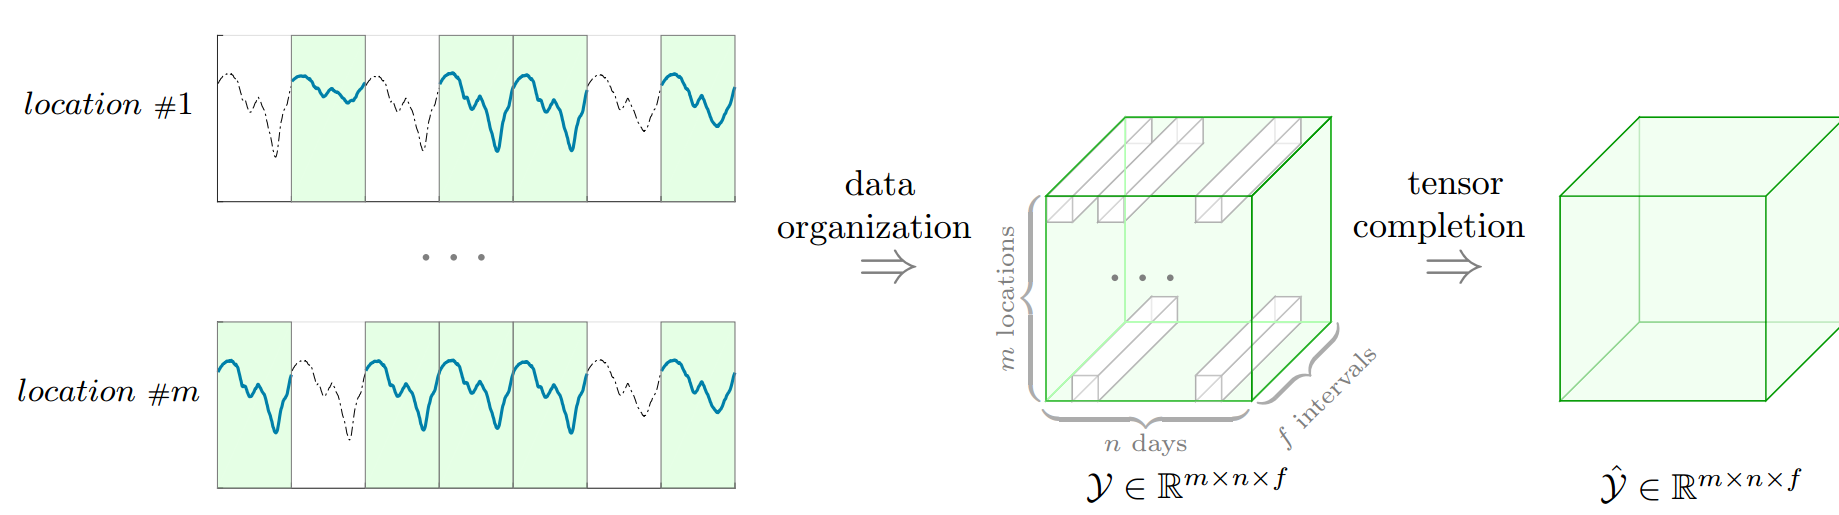

In [7]:
Image("tensor.png", width=1000)

### Test in interval of the time series with fancyimpute


First, the dataframe is read where all the sensor data is contained in the time intervals that are interesting to observe.

In [153]:
#super_df = pd.read_csv('./data/dfv3.csv', header=0, index_col=0)
super_df = pd.read_csv('./data/superdfi.csv', header=0, index_col=0)
aux = super_df.copy(deep=True)

A dataframe sample is taken from the data of three sensors and the NAN values are removed.

Due to the fact that the original data has NAN values, for the performance evaluation experiment these values will be excluded to pass a matrix without null values through the models and to be able to apply the performance indicators (MAE, MSE).

In [154]:
aux = pd.pivot_table(data=aux,values='PM2_MOY',index='Sensor',columns= ['Date', 'Hour'])
#aux = aux.fillna(method='bfill')
aux = aux.dropna(axis= 1)
columnst = aux.columns
indext = aux.index

In [155]:
aux.isnull().sum().sum()

0

In [156]:
aux= aux.T.reset_index(drop=True).T
aux.reset_index()

,Sensor,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271
0,sensor10v2.csv,9.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,5.0,5.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,19.0,19.0,20.0,20.0,20.0,21.0,21.0,21.0,21.0,21.0,22.0,22.0,22.0,22.0,22.0,26.0,25.0,24.0,22.0,21.0,20.0,20.0,20.0,20.0,36.0,37.0,48.0,49.0,50.0,51.0,51.0,50.0,50.0,49.0,49.0,48.0,47.0,41.0,40.0,39.0
1,sensor11v2.csv,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,7.0,7.0,10.0,10.0,10.0,10.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0
2,sensor12v2.csv,7.0,7.0,7.0,7.0,7.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0,5.0,5.0,5.0,5.0,4.0,3.0,3.0,4.0,4.0,4.0,5.0,6.0,6.0,7.0,7.0,9.0,9.0,9.0,9.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,5.0,5.0,5.0
3,sensor13v2.csv,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,...,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,8.0,8.0,7.0,6.0,6.0,5.0,5.0,5.0,5.0,7.0,8.0,10.0,11.0,11.0,12.0,12.0,12.0,13.0,13.0,13.0,13.0,13.0,16.0,16.0,16.0
4,sensor14v2.csv,9.0,8.0,8.0,8.0,8.0,8.0,8.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,17.0,18.0,19.0,20.0,21.0,21.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,23.0,25.0,25.0,25.0,23.0,19.0,19.0,19.0,19.0,19.0,35.0,37.0,52.0,54.0,55.0,54.0,54.0,53.0,52.0,52.0,51.0,51.0,49.0,41.0,40.0,38.0
5,sensor15v2.csv,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,8.0,8.0,8.0,7.0,6.0,6.0,6.0,6.0,6.0,8.0,8.0,11.0,11.0,11.0,12.0,12.0,12.0,12.0,13.0,13.0,13.0,13.0,12.0,12.0,12.0
6,sensor16v2.csv,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,...,7.0,7.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,10.0,10.0,10.0,9.0,8.0,8.0,7.0,7.0,7.0,14.0,14.0,19.0,18.0,17.0,17.0,17.0,17.0,16.0,16.0,16.0,15.0,15.0,10.0,10.0,9.0
7,sensor17v2.csv,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,19.0,19.0,19.0,19.0,18.0,17.0,16.0,16.0,17.0,17.0,17.0,18.0,18.0,18.0,18.0,20.0,21.0,22.0,22.0,23.0,23.0,23.0,23.0,23.0,25.0,26.0,28.0,28.0,29.0,29.0,29.0,28.0,28.0,28.0,27.0,27.0,27.0,24.0,24.0,23.0
8,sensor19v2.csv,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,3.0
9,sensor1v2.csv,11.0,11.0,10.0,10.0,10.0,10.0,9.0,9.0,9.0,9.0,9.0,8.0,8.0,8.0,8.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,27.0,29.0,30.0,31.0,31.0,32.0,33.0,33.0,33.0,33.0,33.0,34.0,34.0,35.0,35.0,41.0,41.0,40.0,37.0,32.0,32.0,31.0,31.0,31.0,59.0,61.0,89.0,93.0,95.0,95.0,94.0,93.0,92.0,92.0,91.0,90.0,88.0,71.0,69.0,66.0


In [25]:
aux.shape

(43, 272)

In [26]:
super_df.describe()

,Hour,PM2_MIN,PM2_MAX,PM2_MOY
count,63984.000000,55474.000000,55474.000000,55474.000000
mean,11.500000,11.469643,17.725872,14.333201
std,6.922241,18.122178,28.980264,23.093834
min,0.000000,0.000000,0.000000,0.000000
25%,5.750000,3.000000,4.000000,3.000000
50%,11.500000,6.000000,8.000000,7.000000
75%,17.250000,13.000000,18.000000,15.000000
max,23.000000,313.000000,318.000000,315.000000


We transform the df into a numpy vector and randomly replace existing values with NAN values, we also create a mask of the positions of these values for later comparison.

In [27]:
f = 25 # window of the time series
outTensor = np.array([]).reshape(aux.shape[0], 0, f)

for t in range(0, aux.shape[1], f):
  auxTenso = aux.values[:,t:t+f][:, None]
  auxTenso = np.pad(auxTenso, ((0,0),(0,0),(0,f-auxTenso.shape[2])), mode='constant')
  outTensor = np.append(outTensor, auxTenso, axis = 1)
print(outTensor.shape)

(43, 11, 25)


Percentage of NAN values in the Tensor 23%

In [28]:
np.isnan(outTensor).sum()/np.prod(outTensor.shape)

0.0

### Functions

In [29]:
def plotTs(actual, imputed, title):
  plt.figure(figsize=(20,10))
  plt.plot(actual, 'r', label='Actual', linewidth=0.8)
  plt.plot(imputed, 'b', label='Imputated', linewidth=0.8 )
  plt.title(title, size = 20)
  plt.xlabel('Time',size=18)
  plt.ylabel('Average PM2.5',size=18)
  plt.legend(fontsize=20)
  plt.show()

In [30]:
def plotTS (observed_data, imputed_data, sensor, title):

  s = sensor.split('.')[0]
  s=s[0:8] if len(s) == 10 else s[0:7] 
  plt.figure(figsize=(20,10))
  plt.subplot(211)
  plt.plot(observed_data[sensor],'r')
  plt.title('Original data, ' + s, size=20)
  plt.xlabel('Time',size=18)
  plt.ylabel('Average PM2.5',size=18)
  plt.subplots_adjust(hspace=0.4)
  
  #plt.figure(figsize=(20,5))
  plt.subplot(212)
  plt.plot(imputed_data[sensor],'b')
  plt.title(title + ', ' + s, size=20)
  plt.xlabel('Time',size=18)
  plt.ylabel('Average PM2.5',size=18)

  plt.show()



In [31]:
def scatter(x,y,title):

  fig, ax = plt.subplots()
  ax.scatter(x, y, c='blue')
  line = mlines.Line2D([0, 1], [0, 1], color='black')
  transform = ax.transAxes
  line.set_transform(transform)
  ax.add_line(line)
  plt.title(title)
  plt.xlabel('Observed value')
  plt.ylabel('Imputed value')
  plt.show()

## Bayesian Probabilistic Matrix Factorization (BPMF)

In [3]:
!pip install -U scipy

     |████████████████████████████████| 27.4MB 111kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [32]:
import numpy as np
from numpy.linalg import inv as inv
from numpy.random import normal as normrnd
from scipy.linalg import khatri_rao as kr_prod
from scipy.stats import wishart
from numpy.linalg import solve as solve
from scipy.linalg import cholesky as cholesky_upper
from scipy.linalg import solve_triangular as solve_ut
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
def mvnrnd_pre(mu, Lambda):
    src = normrnd(size = (mu.shape[0],))
    return solve_ut(cholesky_upper(Lambda, overwrite_a = True, check_finite = False), 
                    src, lower = False, check_finite = False, overwrite_b = True) + mu

def cov_mat(mat, mat_bar):
    mat = mat - mat_bar
    return mat.T @ mat

Sample factor $\boldsymbol{W}$

In [34]:
def sample_factor_w(tau_sparse_mat, tau_ind, W, X, tau, beta0 = 1, vargin = 0):
    """Sampling N-by-R factor matrix W and its hyperparameters (mu_w, Lambda_w)."""
    
    dim1, rank = W.shape
    W_bar = np.mean(W, axis = 0)
    temp = dim1 / (dim1 + beta0)
    var_mu_hyper = temp * W_bar
    var_W_hyper = inv(np.eye(rank) + cov_mat(W, W_bar) + temp * beta0 * np.outer(W_bar, W_bar))
    var_Lambda_hyper = wishart.rvs(df = dim1 + rank, scale = var_W_hyper)
    var_mu_hyper = mvnrnd_pre(var_mu_hyper, (dim1 + beta0) * var_Lambda_hyper)
    
    if dim1 * rank ** 2 > 1e+8:
        vargin = 1
    
    if vargin == 0:
        var1 = X.T
        var2 = kr_prod(var1, var1)
        var3 = (var2 @ tau_ind.T).reshape([rank, rank, dim1]) + var_Lambda_hyper[:, :, np.newaxis]
        var4 = var1 @ tau_sparse_mat.T + (var_Lambda_hyper @ var_mu_hyper)[:, np.newaxis]
        for i in range(dim1):
            W[i, :] = mvnrnd_pre(solve(var3[:, :, i], var4[:, i]), var3[:, :, i])
    elif vargin == 1:
        for i in range(dim1):
            pos0 = np.where(sparse_mat[i, :] != 0)
            Xt = X[pos0[0], :]
            var_mu = tau * Xt.T @ sparse_mat[i, pos0[0]] + var_Lambda_hyper @ var_mu_hyper
            var_Lambda = tau * Xt.T @ Xt + var_Lambda_hyper
            W[i, :] = mvnrnd_pre(solve(var_Lambda, var_mu), var_Lambda)
    
    return W

Sample factor $\boldsymbol{X}$

In [35]:
def sample_factor_x(tau_sparse_mat, tau_ind, W, X, beta0 = 1):
    """Sampling T-by-R factor matrix X and its hyperparameters (mu_x, Lambda_x)."""
    
    dim2, rank = X.shape
    X_bar = np.mean(X, axis = 0)
    temp = dim2 / (dim2 + beta0)
    var_mu_hyper = temp * X_bar
    var_X_hyper = inv(np.eye(rank) + cov_mat(X, X_bar) + temp * beta0 * np.outer(X_bar, X_bar))
    var_Lambda_hyper = wishart.rvs(df = dim2 + rank, scale = var_X_hyper)
    var_mu_hyper = mvnrnd_pre(var_mu_hyper, (dim2 + beta0) * var_Lambda_hyper)
    
    
    var1 = W.T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ tau_ind).reshape([rank, rank, dim2]) + var_Lambda_hyper[:, :, np.newaxis]
    var4 = var1 @ tau_sparse_mat + (var_Lambda_hyper @ var_mu_hyper)[:, np.newaxis]
    for t in range(dim2):
        X[t, :] = mvnrnd_pre(solve(var3[:, :, t], var4[:, t]), var3[:, :, t])

    return X

Sampling Precision $\tau$

In [36]:
def sample_precision_tau(sparse_mat, mat_hat, ind):
    var_alpha = 1e-6 + 0.5 * np.sum(ind)
    var_beta = 1e-6 + 0.5 * np.sum(((sparse_mat - mat_hat) ** 2) * ind)
    return np.random.gamma(var_alpha, 1 / var_beta)

In [37]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

BPMF Implementation

In [38]:

def BPMF(dense_mat, sparse_mat, init, rank, burn_iter, gibbs_iter):
    """Bayesian Probabilistic Matrix Factorization, BPMF."""
    
    dim1, dim2 = sparse_mat.shape
    W = init["W"]
    X = init["X"]
    if np.isnan(sparse_mat).any() == False:
        ind = sparse_mat != 0
        pos_obs = np.where(ind)
        pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
    elif np.isnan(sparse_mat).any() == True:
        pos_test = np.where((dense_mat != 0) & (np.isnan(sparse_mat)))
        ind = ~np.isnan(sparse_mat)
        pos_obs = np.where(ind)
        sparse_mat[np.isnan(sparse_mat)] = 0
    dense_test = dense_mat[pos_test]
    del dense_mat
    tau = 1
    W_plus = np.zeros((dim1, rank))
    X_plus = np.zeros((dim2, rank))
    temp_hat = np.zeros(sparse_mat.shape)
    show_iter = 200
    mat_hat_plus = np.zeros(sparse_mat.shape)
    for it in range(burn_iter + gibbs_iter):
        tau_ind = tau * ind
        tau_sparse_mat = tau * sparse_mat
        W = sample_factor_w(tau_sparse_mat, tau_ind, W, X, tau)
        X = sample_factor_x(tau_sparse_mat, tau_ind, W, X)
        mat_hat = W @ X.T
        tau = sample_precision_tau(sparse_mat, mat_hat, ind)
        temp_hat += mat_hat
        if (it + 1) % show_iter == 0 and it < burn_iter:
            temp_hat = temp_hat / show_iter
            print('Iter: {}'.format(it + 1))
            print('MAPE: {:.6}'.format(compute_mape(dense_test, temp_hat[pos_test])))
            print('RMSE: {:.6}'.format(compute_rmse(dense_test, temp_hat[pos_test])))
            temp_hat = np.zeros(sparse_mat.shape)
            print()
        if it + 1 > burn_iter:
            W_plus += W
            X_plus += X
            mat_hat_plus += mat_hat
    mat_hat = mat_hat_plus / gibbs_iter
    W = W_plus / gibbs_iter
    X = X_plus / gibbs_iter
    print('Imputation MAPE: {:.6}'.format(compute_mape(dense_test, mat_hat[pos_test])))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_test, mat_hat[pos_test])))
    print()
    
    return mat_hat, W, X

### Non-random missing (NM) tests 

Scenario setting:


*   Tensor size: $43\times 11\times 25$ (# sensors, hours, whole time series)
*   Non-random missing (NM)
*   30% missing rate










 


In [40]:
import scipy.io



tensor = np.copy(outTensor)
random_matrix = np.random.rand(outTensor.shape[0],outTensor.shape[1])
random_tensor = np.random.rand(outTensor.shape[0],outTensor.shape[1], outTensor.shape[2])
dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.3

## Non-random missing (NM)
binary_tensor = np.zeros(tensor.shape)
for i1 in range(tensor.shape[0]):
    for i2 in range(tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
sparse_mat = np.multiply(dense_mat, binary_mat)

In [41]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 60
init = {"W": 0.01 * np.random.randn(dim1, rank), "X": 0.01 * np.random.randn(dim2, rank)}
burn_iter = 1000
gibbs_iter = 200
mat_hat, W, X = BPMF(dense_mat, sparse_mat, init, rank, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 200
MAPE: 0.411302
RMSE: 13.2501

Iter: 400
MAPE: 0.428342
RMSE: 14.0042

Iter: 600
MAPE: 0.453905
RMSE: 13.583

Iter: 800
MAPE: 0.477802
RMSE: 13.6295

Iter: 1000
MAPE: 0.476604
RMSE: 13.6809

Imputation MAPE: 0.464738
Imputation RMSE: 13.3941

Running time: 153 seconds


We can observe that the performance of the algorithm is worse when we assume that the data is non-random missing.

### Random Mising Test 

Tensor size:  43×11×25  (# sensors, hours, intervals of hours time series)
Non-random missing (NM)
30% missing rate

In [42]:
import scipy.io

tensor = np.copy(outTensor)
random_matrix = np.random.rand(outTensor.shape[0],outTensor.shape[1])
random_tensor = np.random.rand(outTensor.shape[0],outTensor.shape[1], outTensor.shape[2])
dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.3

## Random missing (RM)
binary_mat = (np.round(random_tensor + 0.5 - missing_rate)
              .reshape([random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]]))
sparse_mat = np.multiply(dense_mat, binary_mat)



*   Low rank: 80
*   The number of burn-in iterations: 1000
* The number of Gibbs iterations: 200







In [43]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 80
init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(dim2, rank)}
burn_iter = 1000
gibbs_iter = 200
mat_hat, W, X = BPMF(dense_mat, sparse_mat, init, rank, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 200
MAPE: 0.112104
RMSE: 6.78446

Iter: 400
MAPE: 0.112946
RMSE: 6.1662

Iter: 600
MAPE: 0.116241
RMSE: 6.30852

Iter: 800
MAPE: 0.115146
RMSE: 6.16326

Iter: 1000
MAPE: 0.118825
RMSE: 6.51089

Imputation MAPE: 0.115161
Imputation RMSE: 5.74591

Running time: 248 seconds


dense_mat is the original vector of data and mat_hat is the imputated vector in each position of these vector we can observe the time series distribution of a different sensor

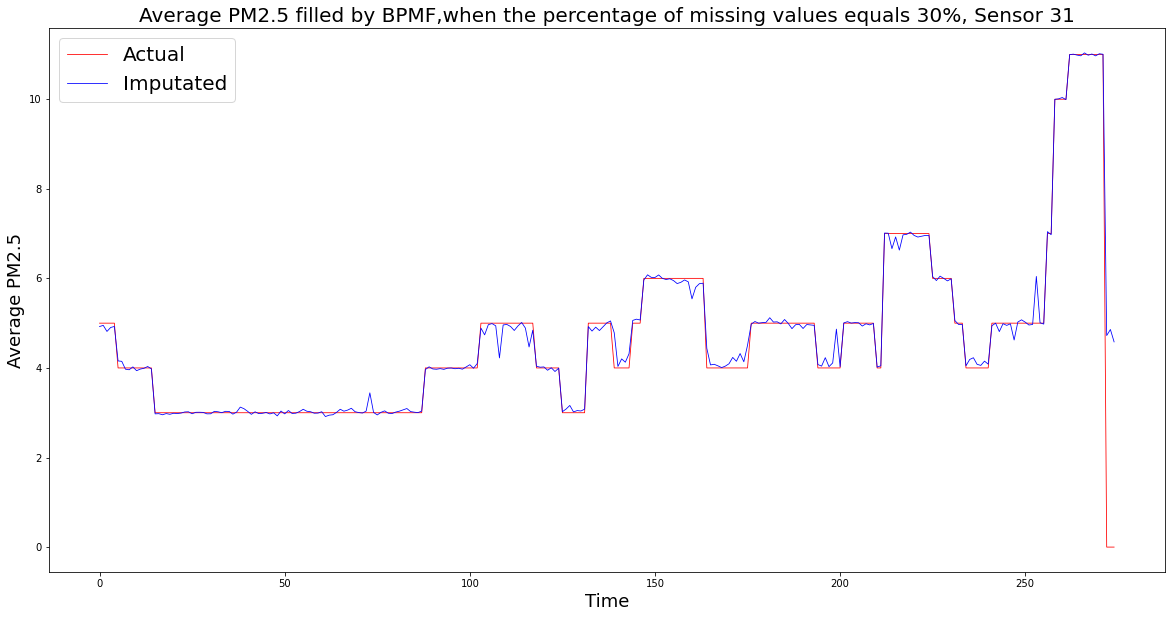

In [44]:
plotTs(dense_mat[12], mat_hat[12], title='Average PM2.5 filled by BPMF,when the percentage of missing values equals 30%, Sensor 31')

We can observe that the imputated value is similar to the actual value, and the performance indicators are very small.

## Bayesian Temporal Matrix Factorization (**BTMF**)

In [45]:
import numpy as np
from numpy.linalg import inv as inv
from numpy.random import normal as normrnd
from scipy.linalg import khatri_rao as kr_prod
from scipy.stats import wishart
from scipy.stats import invwishart
from numpy.linalg import solve as solve
from numpy.linalg import cholesky as cholesky_lower
from scipy.linalg import cholesky as cholesky_upper
from scipy.linalg import solve_triangular as solve_ut
import matplotlib.pyplot as plt
%matplotlib inline

Sampling Factor Matrix $W$ and Its Hyperparameters

In [46]:

def mvnrnd_pre(mu, Lambda):
    src = normrnd(size = (mu.shape[0],))
    return solve_ut(cholesky_upper(Lambda, overwrite_a = True, check_finite = False), 
                    src, lower = False, check_finite = False, overwrite_b = True) + mu

def cov_mat(mat, mat_bar):
    mat = mat - mat_bar
    return mat.T @ mat

In [47]:
def sample_factor_w(tau_sparse_mat, tau_ind, W, X, tau, beta0 = 1, vargin = 0):
    """Sampling N-by-R factor matrix W and its hyperparameters (mu_w, Lambda_w)."""
    
    dim1, rank = W.shape
    W_bar = np.mean(W, axis = 0)
    temp = dim1 / (dim1 + beta0)
    var_W_hyper = inv(np.eye(rank) + cov_mat(W, W_bar) + temp * beta0 * np.outer(W_bar, W_bar))
    var_Lambda_hyper = wishart.rvs(df = dim1 + rank, scale = var_W_hyper)
    var_mu_hyper = mvnrnd_pre(temp * W_bar, (dim1 + beta0) * var_Lambda_hyper)
    
    if dim1 * rank ** 2 > 1e+8:
        vargin = 1
    
    if vargin == 0:
        var1 = X.T
        var2 = kr_prod(var1, var1)
        var3 = (var2 @ tau_ind.T).reshape([rank, rank, dim1]) + var_Lambda_hyper[:, :, None]
        var4 = var1 @ tau_sparse_mat.T + (var_Lambda_hyper @ var_mu_hyper)[:, None]
        for i in range(dim1):
            W[i, :] = mvnrnd_pre(solve(var3[:, :, i], var4[:, i]), var3[:, :, i])
    elif vargin == 1:
        for i in range(dim1):
            pos0 = np.where(sparse_mat[i, :] != 0)
            Xt = X[pos0[0], :]
            var_mu = tau[i] * Xt.T @ sparse_mat[i, pos0[0]] + var_Lambda_hyper @ var_mu_hyper
            var_Lambda = tau[i] * Xt.T @ Xt + var_Lambda_hyper
            W[i, :] = mvnrnd_pre(solve(var_Lambda, var_mu), var_Lambda)
    
    return W

Sampling VAR Coefficients $A$ and Its Hyperparameters

In [48]:
def mnrnd(M, U, V):
    """
    Generate matrix normal distributed random matrix.
    M is a m-by-n matrix, U is a m-by-m matrix, and V is a n-by-n matrix.
    """
    dim1, dim2 = M.shape
    X0 = np.random.randn(dim1, dim2)
    P = cholesky_lower(U)
    Q = cholesky_lower(V)
    
    return M + P @ X0 @ Q.T

def sample_var_coefficient(X, time_lags):
    dim, rank = X.shape
    d = time_lags.shape[0]
    tmax = np.max(time_lags)
    
    Z_mat = X[tmax : dim, :]
    Q_mat = np.zeros((dim - tmax, rank * d))
    for k in range(d):
        Q_mat[:, k * rank : (k + 1) * rank] = X[tmax - time_lags[k] : dim - time_lags[k], :]
    var_Psi0 = np.eye(rank * d) + Q_mat.T @ Q_mat
    var_Psi = inv(var_Psi0)
    var_M = var_Psi @ Q_mat.T @ Z_mat
    var_S = np.eye(rank) + Z_mat.T @ Z_mat - var_M.T @ var_Psi0 @ var_M
    Sigma = invwishart.rvs(df = rank + dim - tmax, scale = var_S)
    
    return mnrnd(var_M, var_Psi, Sigma), Sigma

Sampling Factor Matrix $X$

In [49]:
def sample_factor_x(tau_sparse_mat, tau_ind, time_lags, W, X, A, Lambda_x):
    """Sampling T-by-R factor matrix X."""
    
    dim2, rank = X.shape
    tmax = np.max(time_lags)
    tmin = np.min(time_lags)
    d = time_lags.shape[0]
    A0 = np.dstack([A] * d)
    for k in range(d):
        A0[k * rank : (k + 1) * rank, :, k] = 0
    mat0 = Lambda_x @ A.T
    mat1 = np.einsum('kij, jt -> kit', A.reshape([d, rank, rank]), Lambda_x)
    mat2 = np.einsum('kit, kjt -> ij', mat1, A.reshape([d, rank, rank]))
    
    var1 = W.T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ tau_ind).reshape([rank, rank, dim2]) + Lambda_x[:, :, None]
    var4 = var1 @ tau_sparse_mat
    for t in range(dim2):
        Mt = np.zeros((rank, rank))
        Nt = np.zeros(rank)
        Qt = mat0 @ X[t - time_lags, :].reshape(rank * d)
        index = list(range(0, d))
        if t >= dim2 - tmax and t < dim2 - tmin:
            index = list(np.where(t + time_lags < dim2))[0]
        elif t < tmax:
            Qt = np.zeros(rank)
            index = list(np.where(t + time_lags >= tmax))[0]
        if t < dim2 - tmin:
            Mt = mat2.copy()
            temp = np.zeros((rank * d, len(index)))
            n = 0
            for k in index:
                temp[:, n] = X[t + time_lags[k] - time_lags, :].reshape(rank * d)
                n += 1
            temp0 = X[t + time_lags[index], :].T - np.einsum('ijk, ik -> jk', A0[:, :, index], temp)
            Nt = np.einsum('kij, jk -> i', mat1[index, :, :], temp0)
        
        var3[:, :, t] = var3[:, :, t] + Mt
        if t < tmax:
            var3[:, :, t] = var3[:, :, t] - Lambda_x + np.eye(rank)
        X[t, :] = mvnrnd_pre(solve(var3[:, :, t], var4[:, t] + Nt + Qt), var3[:, :, t])

    return X

Sampling Precision $\tau$

In [50]:

def sample_precision_tau(sparse_mat, mat_hat, ind):
    var_alpha = 1e-6 + 0.5 * np.sum(ind, axis = 1)
    var_beta = 1e-6 + 0.5 * np.sum(((sparse_mat - mat_hat) ** 2) * ind, axis = 1)
    return np.random.gamma(var_alpha, 1 / var_beta)

def sample_precision_scalar_tau(sparse_mat, mat_hat, ind):
    var_alpha = 1e-6 + 0.5 * np.sum(ind)
    var_beta = 1e-6 + 0.5 * np.sum(((sparse_mat - mat_hat) ** 2) * ind)
    return np.random.gamma(var_alpha, 1 / var_beta)

Prrformance indicators functions

In [51]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

BTMF Implementation

In [57]:
def BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter, option = "factor"):
    """Bayesian Temporal Matrix Factorization, BTMF."""
    
    dim1, dim2 = sparse_mat.shape
    lossMape = []
    lossRmse = []
    d = time_lags.shape[0]
    W = init["W"]
    X = init["X"]
    if np.isnan(sparse_mat).any() == False:
        ind = sparse_mat != 0
        pos_obs = np.where(ind)
        pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
    elif np.isnan(sparse_mat).any() == True:
        pos_test = np.where((dense_mat != 0) & (np.isnan(sparse_mat)))
        ind = ~np.isnan(sparse_mat)
        pos_obs = np.where(ind)
        sparse_mat[np.isnan(sparse_mat)] = 0
    dense_test = dense_mat[pos_test]
    del dense_mat
    tau = np.ones(dim1)
    W_plus = np.zeros((dim1, rank))
    X_plus = np.zeros((dim2, rank))
    A_plus = np.zeros((rank * d, rank))
    temp_hat = np.zeros(len(pos_test[0]))
    show_iter = 200
    mat_hat_plus = np.zeros((dim1, dim2))
    for it in range(burn_iter + gibbs_iter):
        tau_ind = tau[:, None] * ind
        tau_sparse_mat = tau[:, None] * sparse_mat
        W = sample_factor_w(tau_sparse_mat, tau_ind, W, X, tau)
        A, Sigma = sample_var_coefficient(X, time_lags)
        X = sample_factor_x(tau_sparse_mat, tau_ind, time_lags, W, X, A, inv(Sigma))
        mat_hat = W @ X.T
        if option == "factor":
            tau = sample_precision_tau(sparse_mat, mat_hat, ind)
        elif option == "pca":
            tau = sample_precision_scalar_tau(sparse_mat, mat_hat, ind)
            tau = tau * np.ones(dim1)
        temp_hat += mat_hat[pos_test]
        if (it + 1) % show_iter == 0 and it < burn_iter:
            temp_hat = temp_hat / show_iter
            print('Iter: {}'.format(it + 1))
            print('MAPE: {:.6}'.format(compute_mape(dense_test, temp_hat)))
            print('RMSE: {:.6}'.format(compute_rmse(dense_test, temp_hat)))
            temp_hat = np.zeros(len(pos_test[0]))
            lossMape.append(compute_mape(dense_test, temp_hat))
            lossRmse.append(compute_rmse(dense_test, temp_hat))
            print()
        if it + 1 > burn_iter:
            W_plus += W
            X_plus += X
            A_plus += A
            mat_hat_plus += mat_hat
    mat_hat = mat_hat_plus / gibbs_iter
    W = W_plus / gibbs_iter
    X = X_plus / gibbs_iter
    A = A_plus / gibbs_iter
    print('Imputation MAPE: {:.6}'.format(compute_mape(dense_test, mat_hat[:, : dim2][pos_test])))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_test, mat_hat[:, : dim2][pos_test])))
    print()
    mat_hat[mat_hat < 0] = 0
    
    return mat_hat, W, X, A

### Random Missing tests 

Tensor size:  43×11×25  (# sensors, hours, interval of discrete time series)
Non-random missing (NM)
30% missing rate

In [58]:
import scipy.io

tensor = np.copy(outTensor)
random_matrix = np.random.rand(outTensor.shape[0],outTensor.shape[1])
random_tensor = np.random.rand(outTensor.shape[0],outTensor.shape[1], outTensor.shape[2])
dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.3

## Random missing (RM)
binary_mat = (np.round(random_tensor + 0.5 - missing_rate)
              .reshape([random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]]))
sparse_mat = np.multiply(dense_mat, binary_mat)

In [59]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 80
time_lags = np.array([1, 2, 25])
init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(dim2, rank)}
burn_iter = 1000
gibbs_iter = 200
mat_hat, W, X, A = BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 200
MAPE: 0.101122
RMSE: 6.04315

Iter: 400
MAPE: 0.0955549
RMSE: 6.80726

Iter: 600
MAPE: 0.0913578
RMSE: 7.03187

Iter: 800
MAPE: 0.0896594
RMSE: 6.81459

Iter: 1000
MAPE: 0.0923913
RMSE: 7.14189

Imputation MAPE: 0.0928044
Imputation RMSE: 6.84229

Running time: 477 seconds


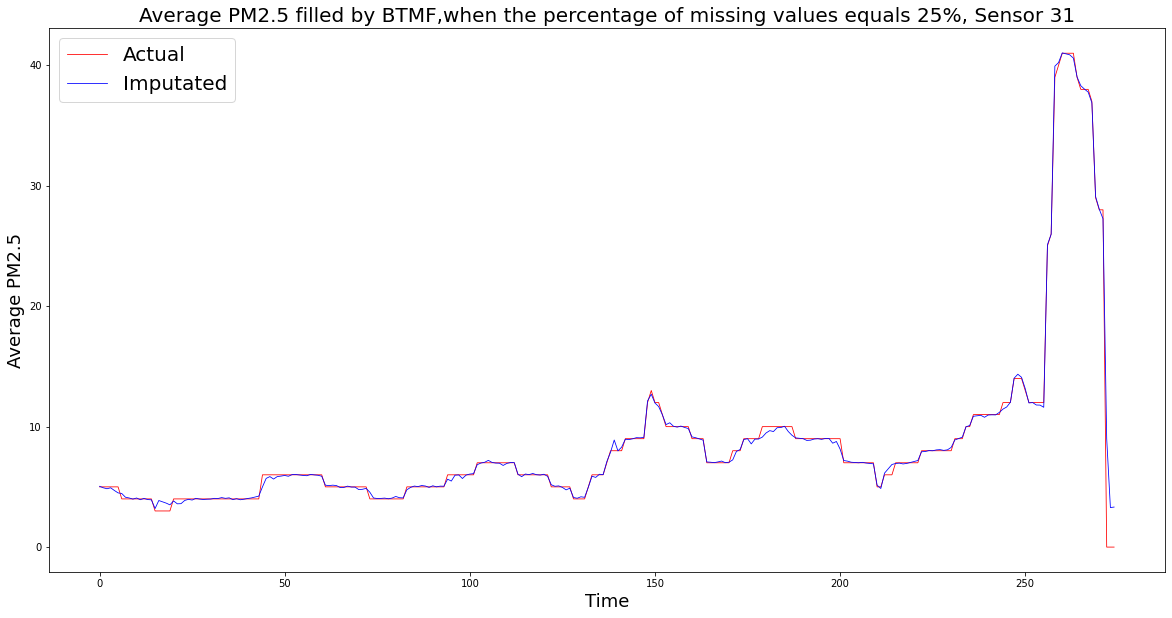

In [60]:
plotTs(dense_mat[25], mat_hat[25], title='Average PM2.5 filled by BTMF,when the percentage of missing values equals 25%, Sensor 31')

In [61]:
np.isnan(mat_hat).sum()

0

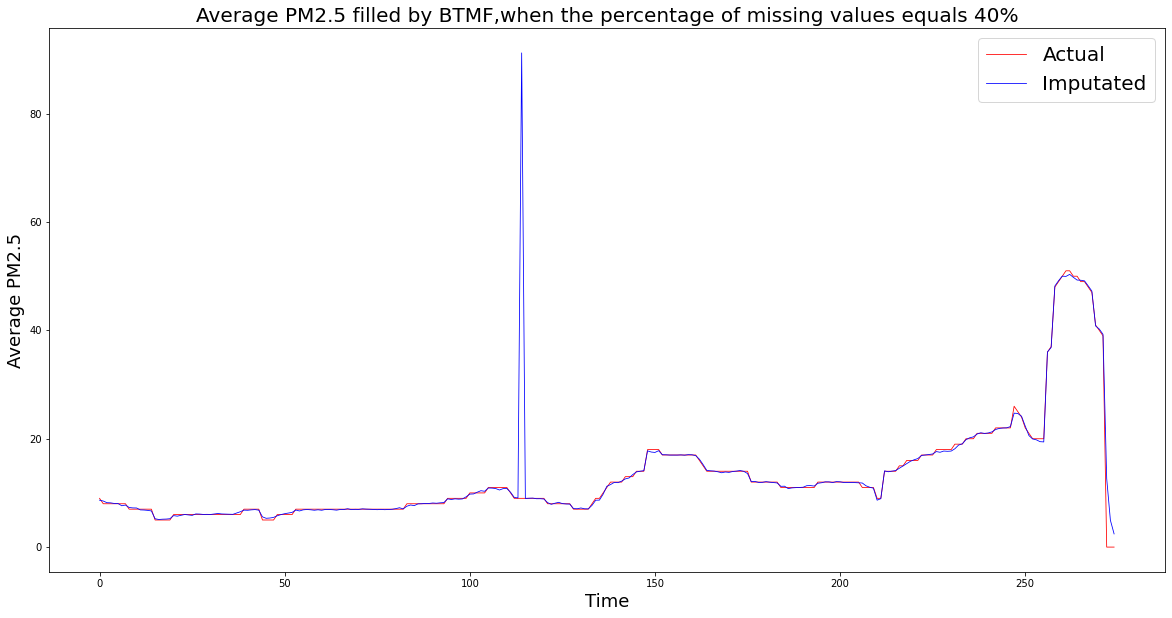

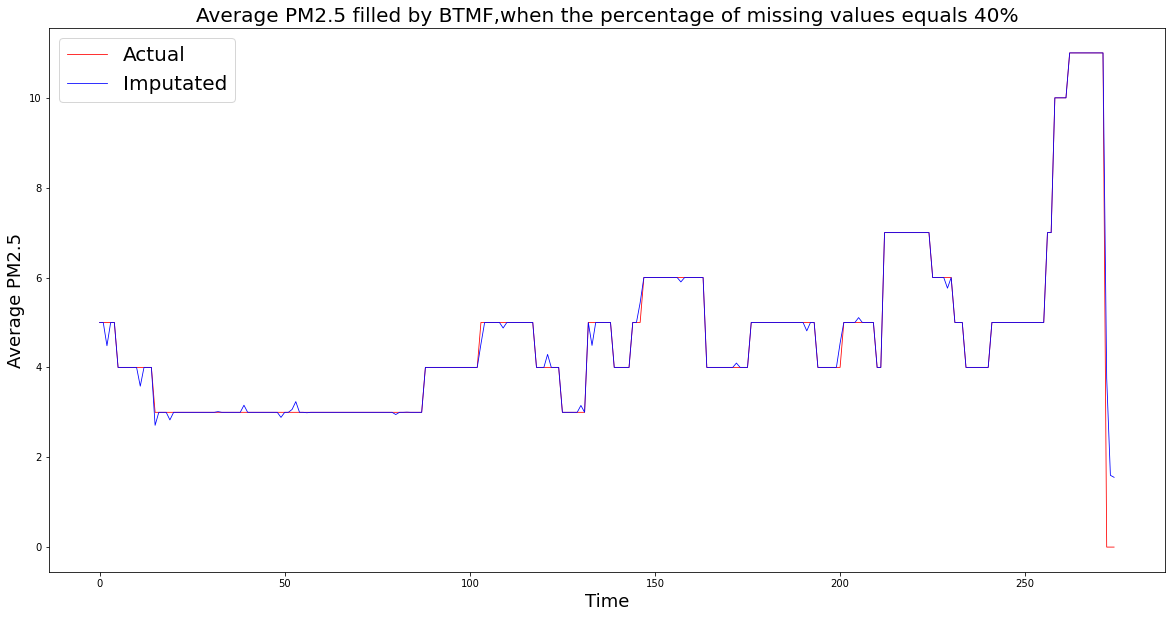

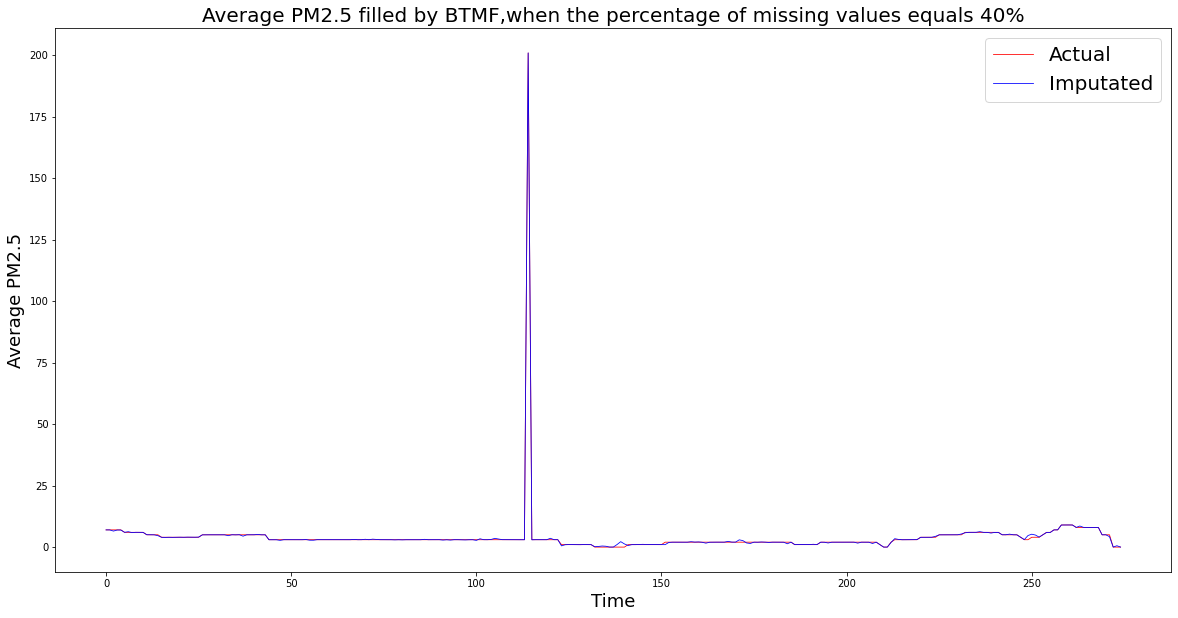

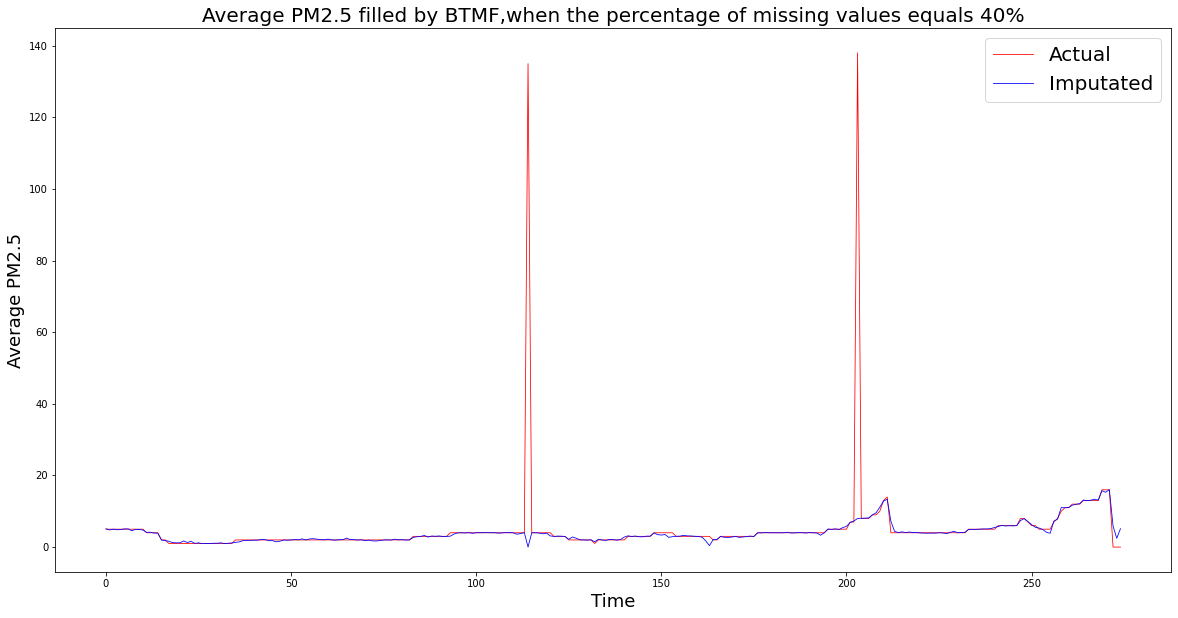

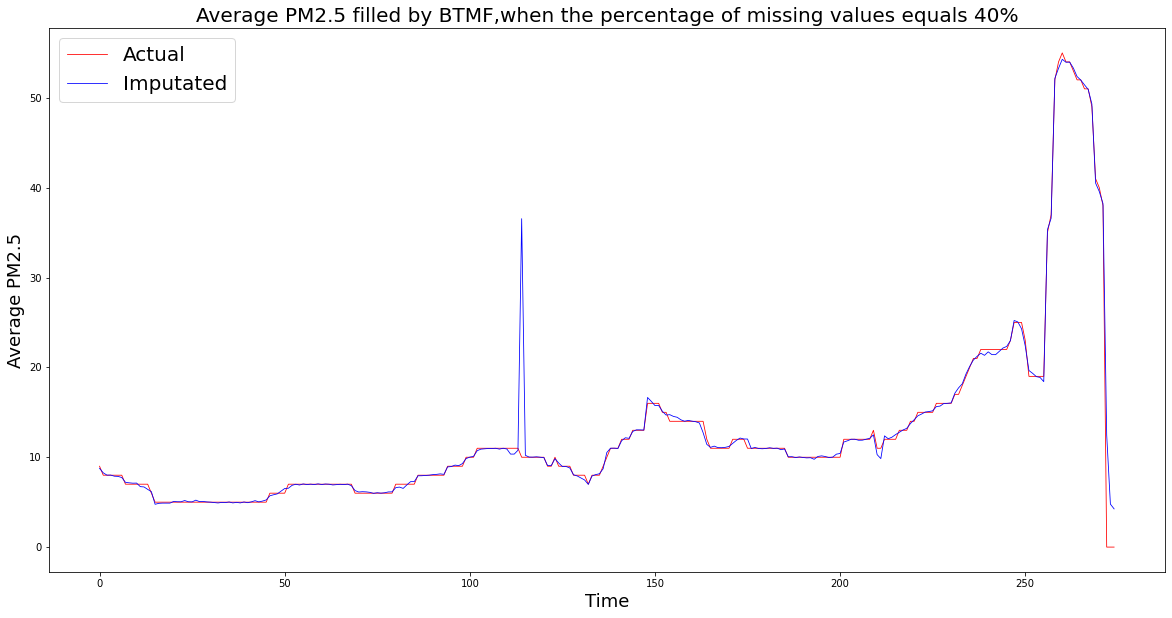

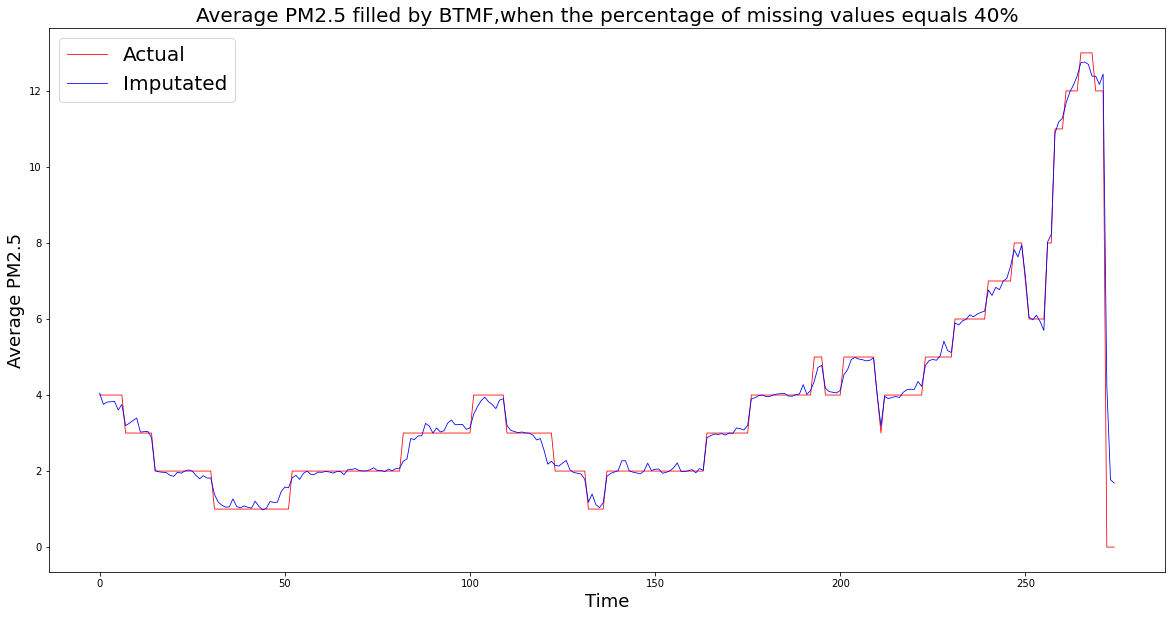

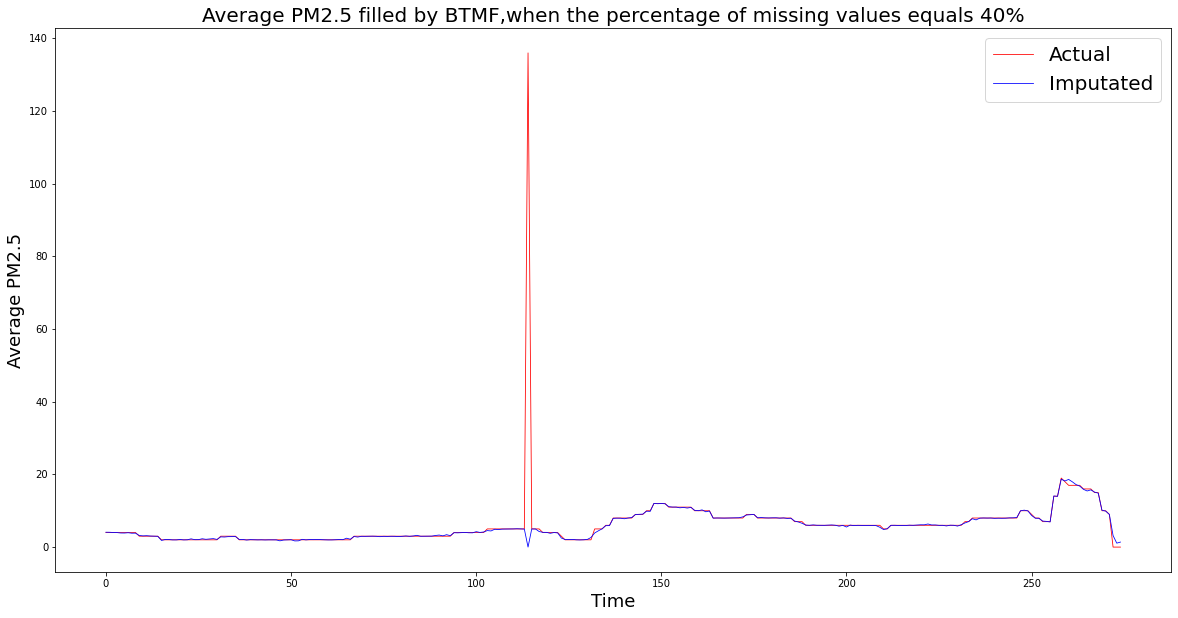

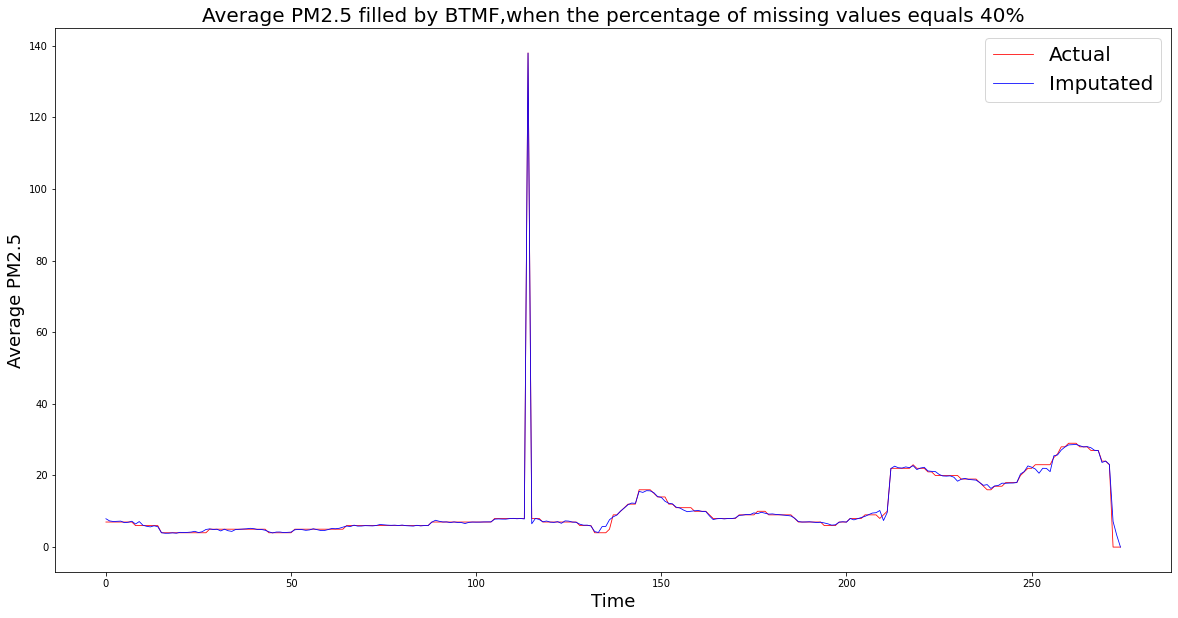

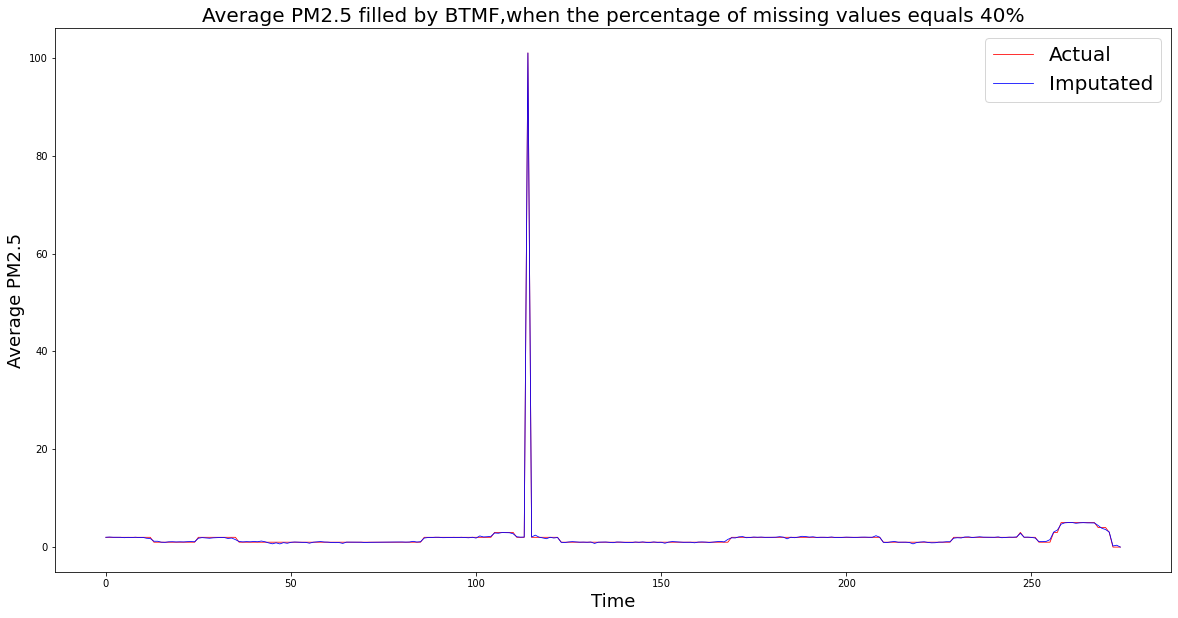

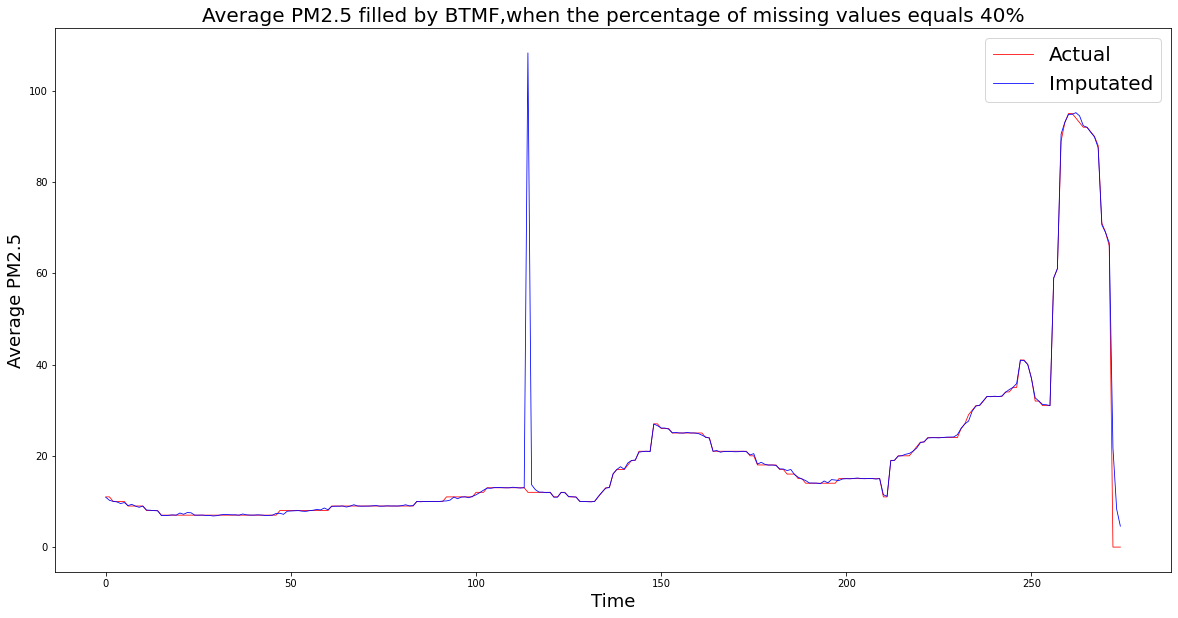

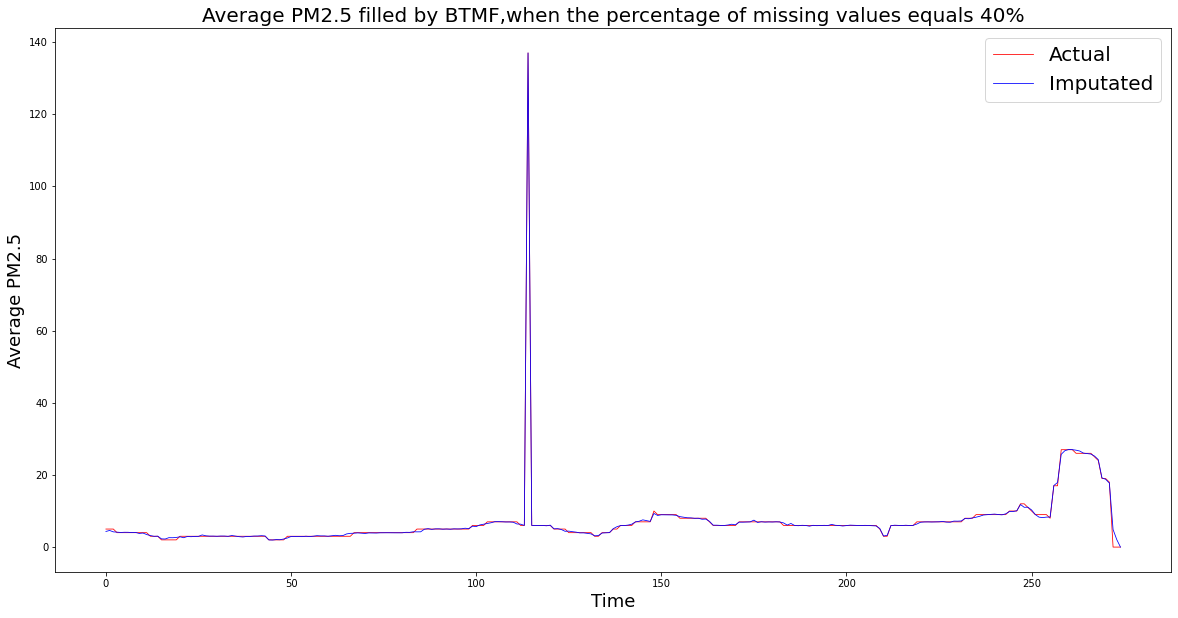

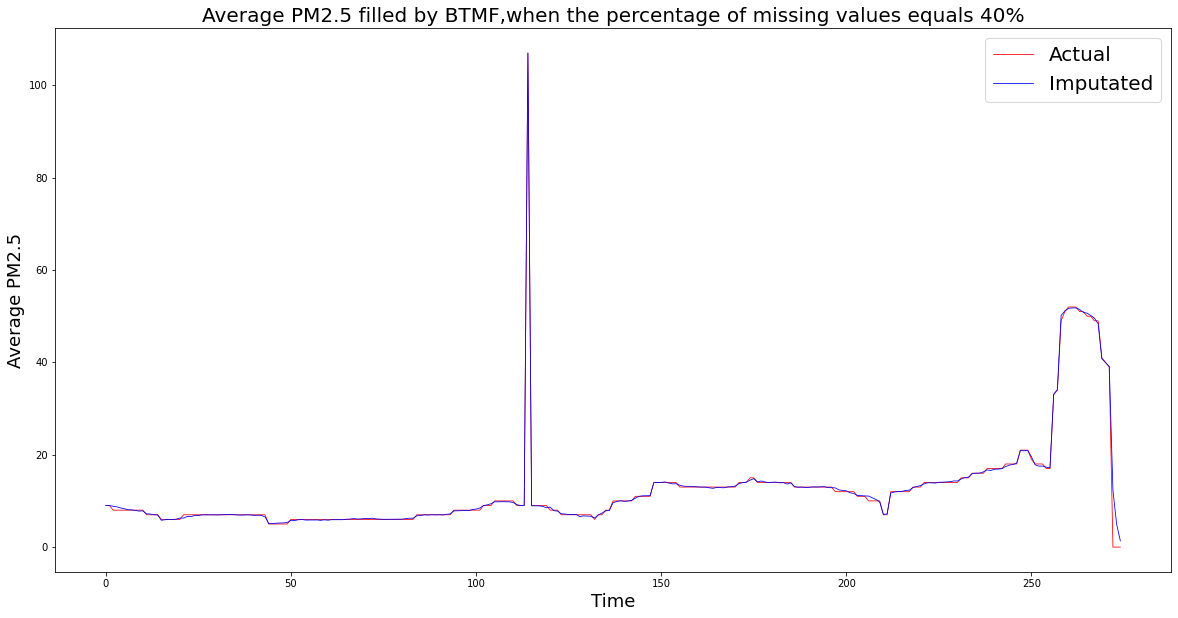

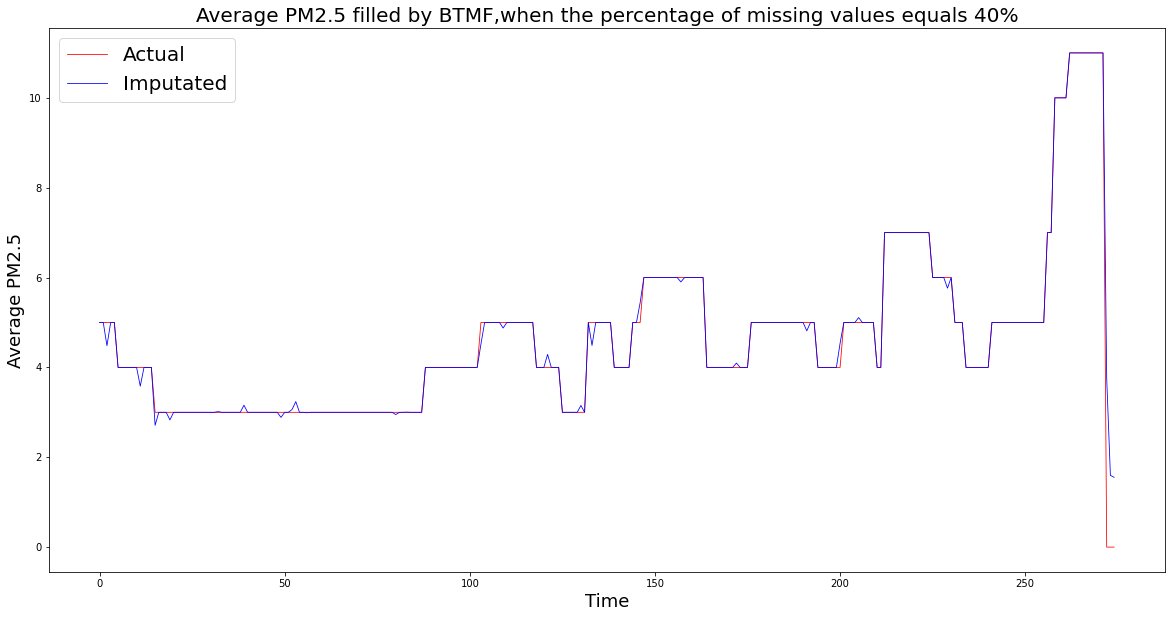

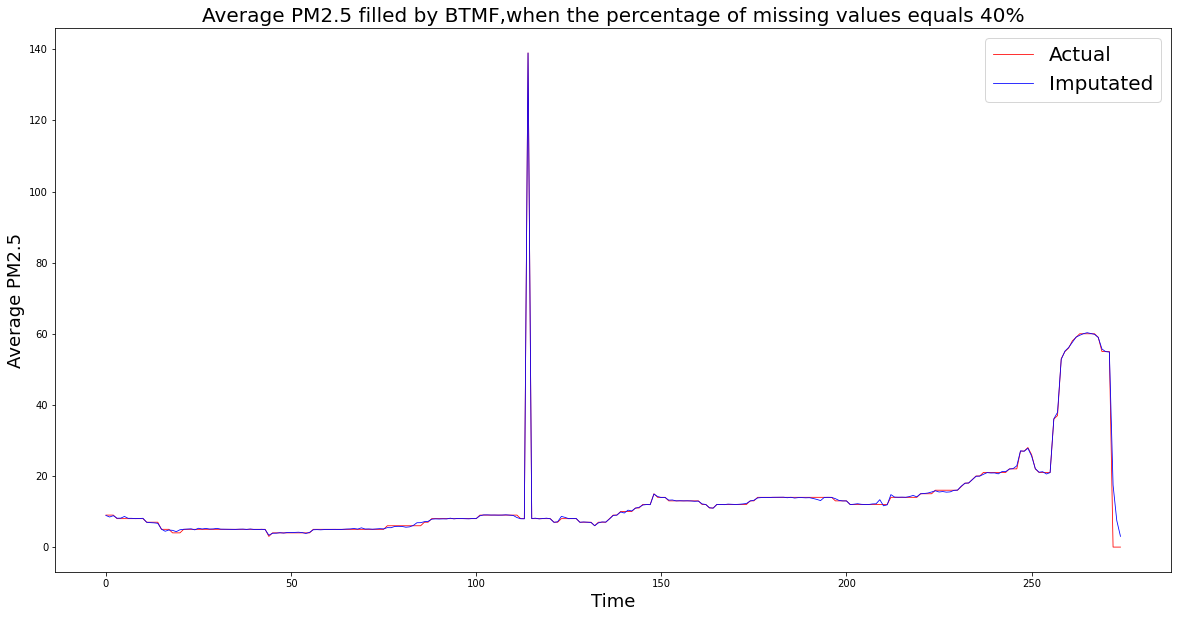

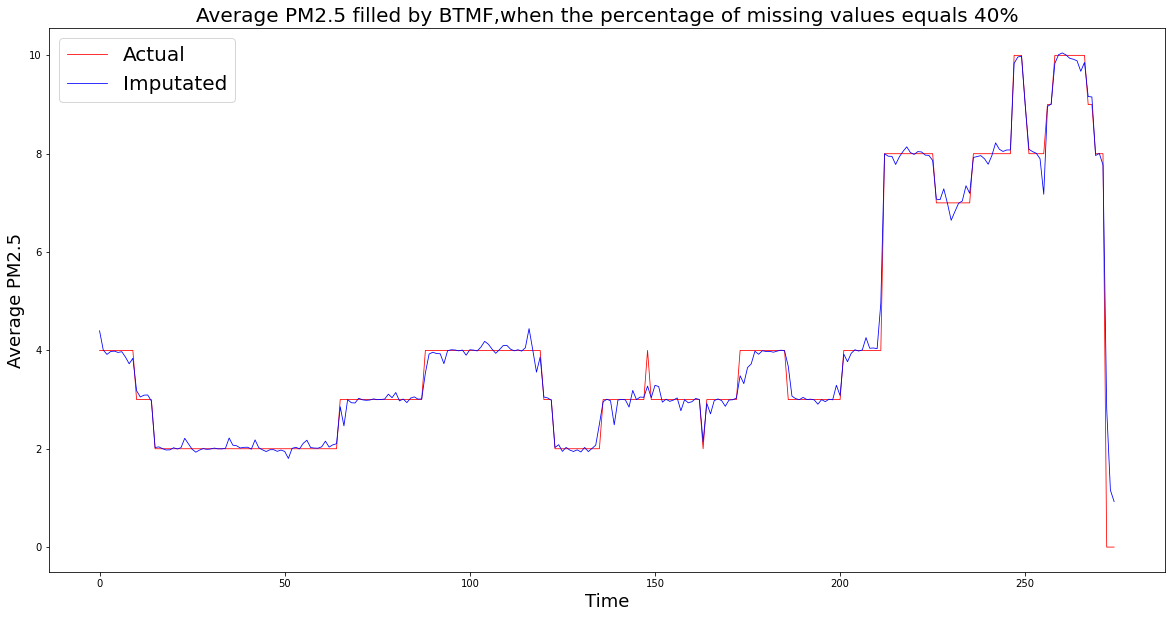

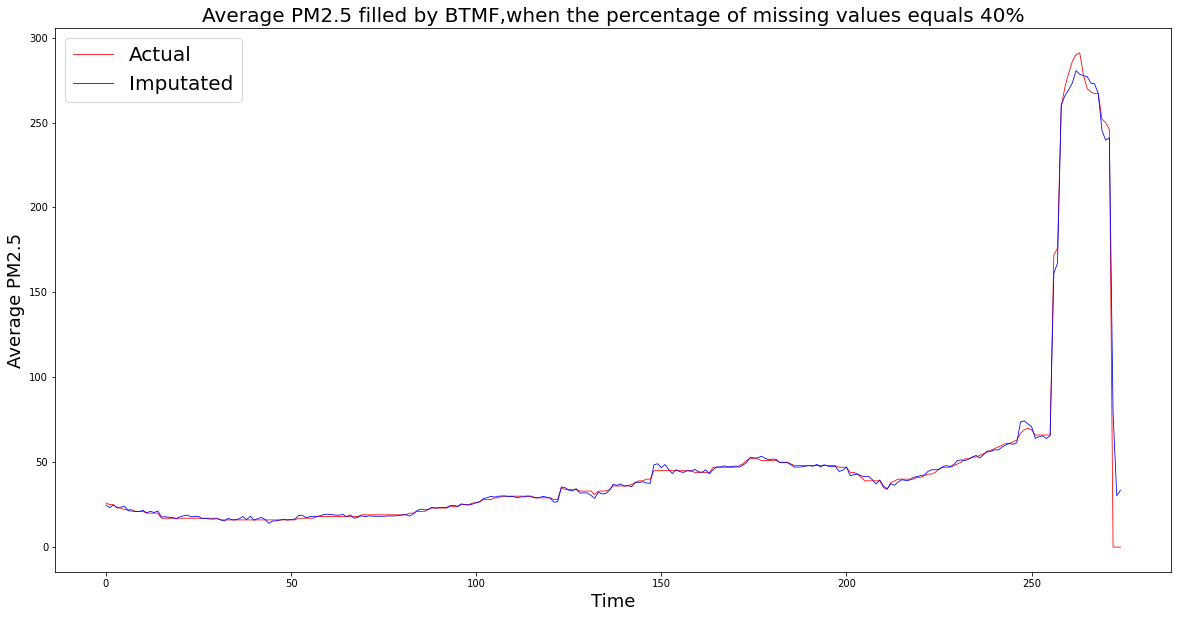

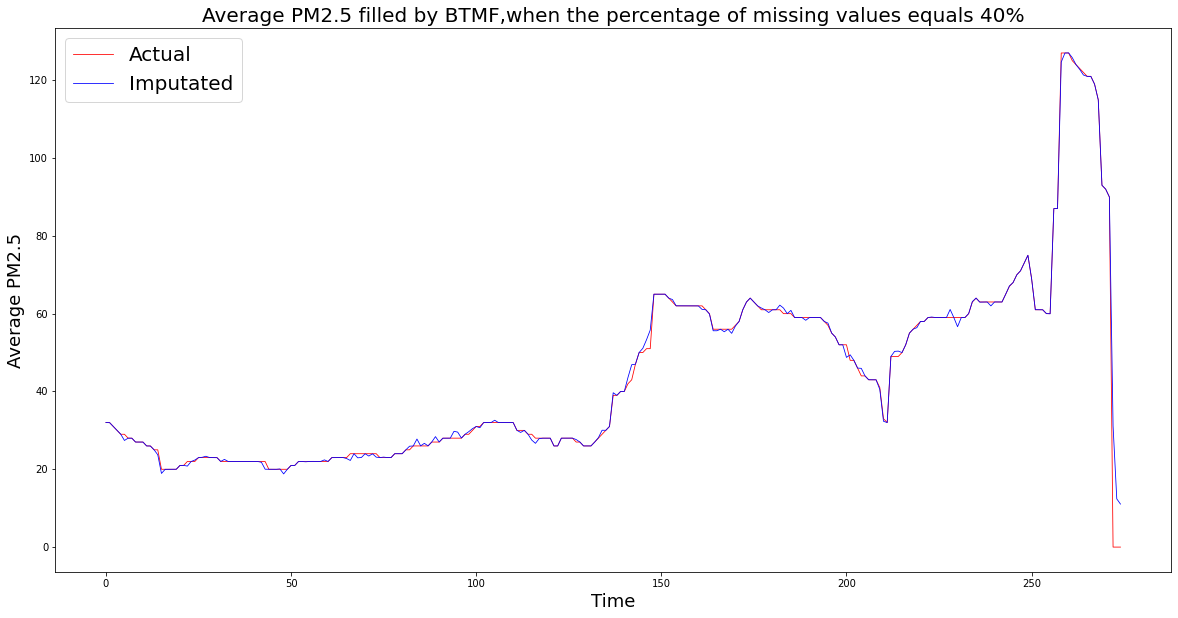

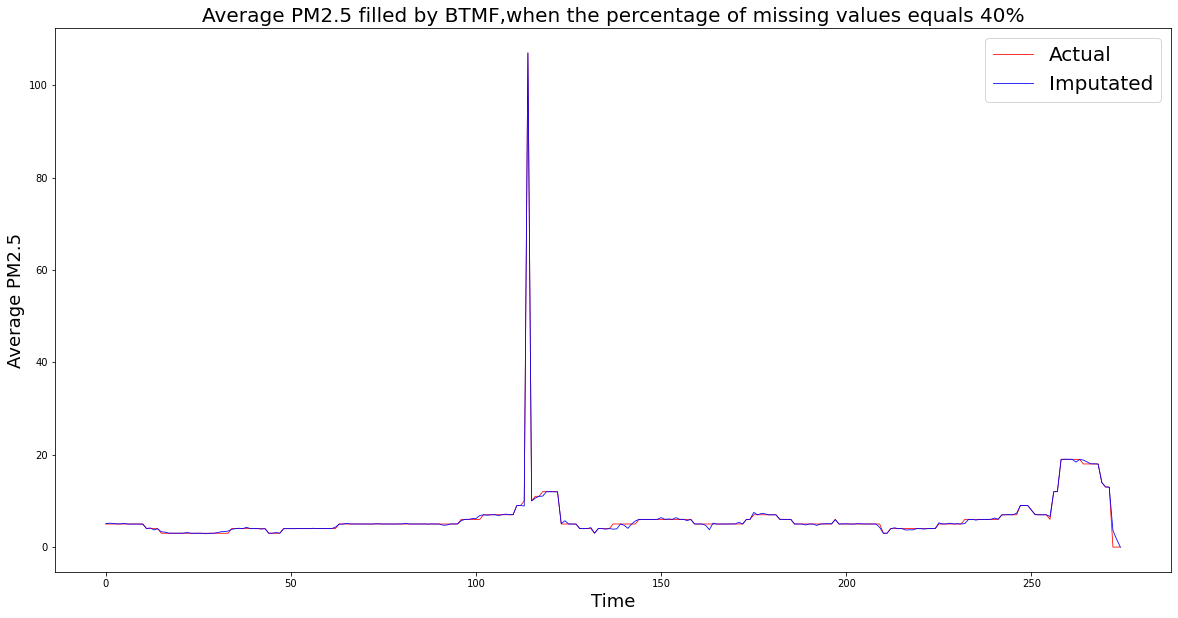

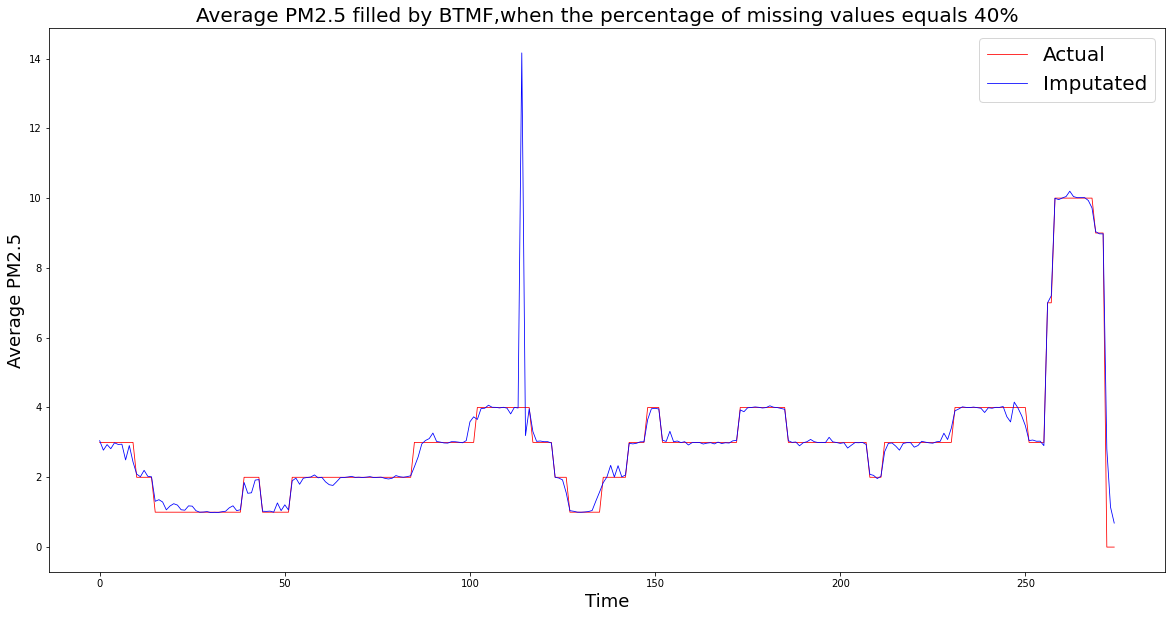

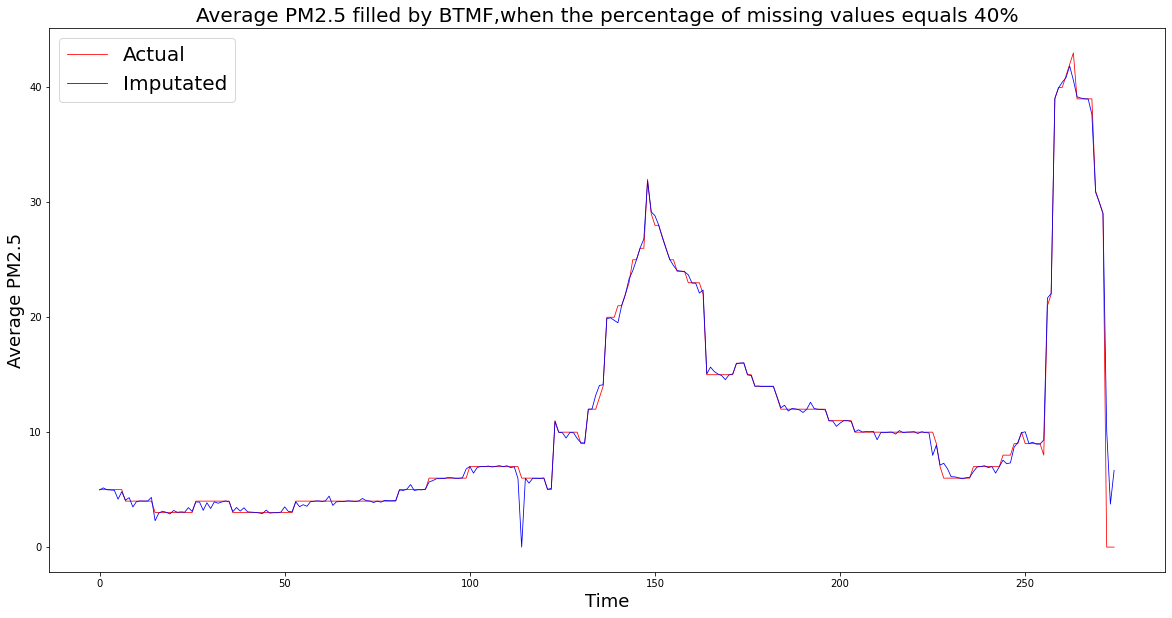

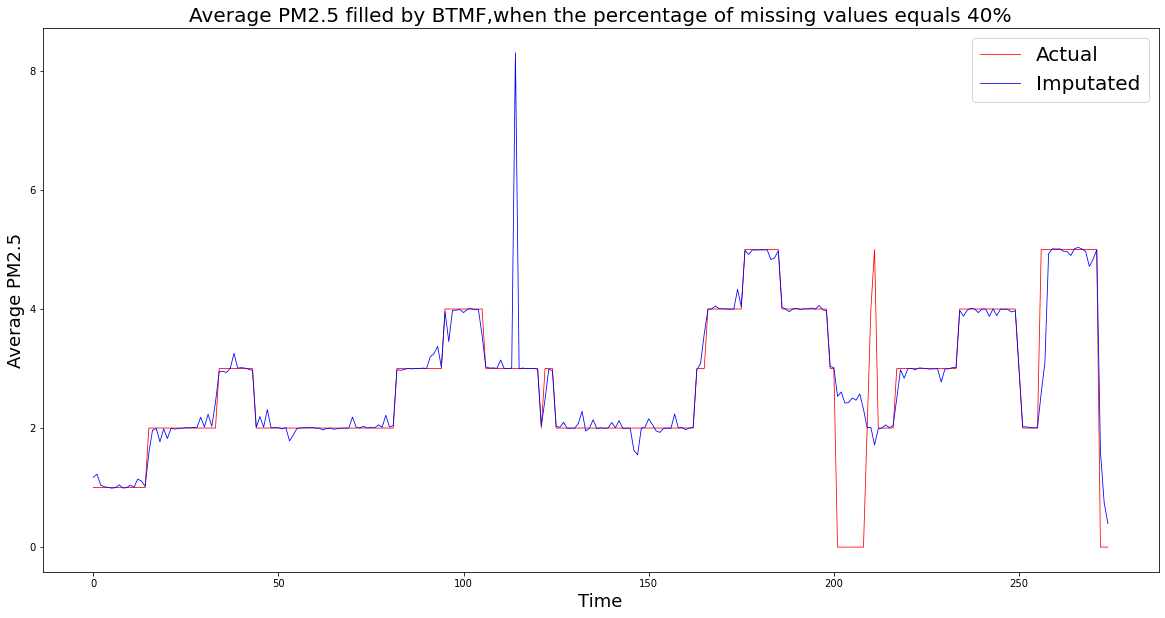

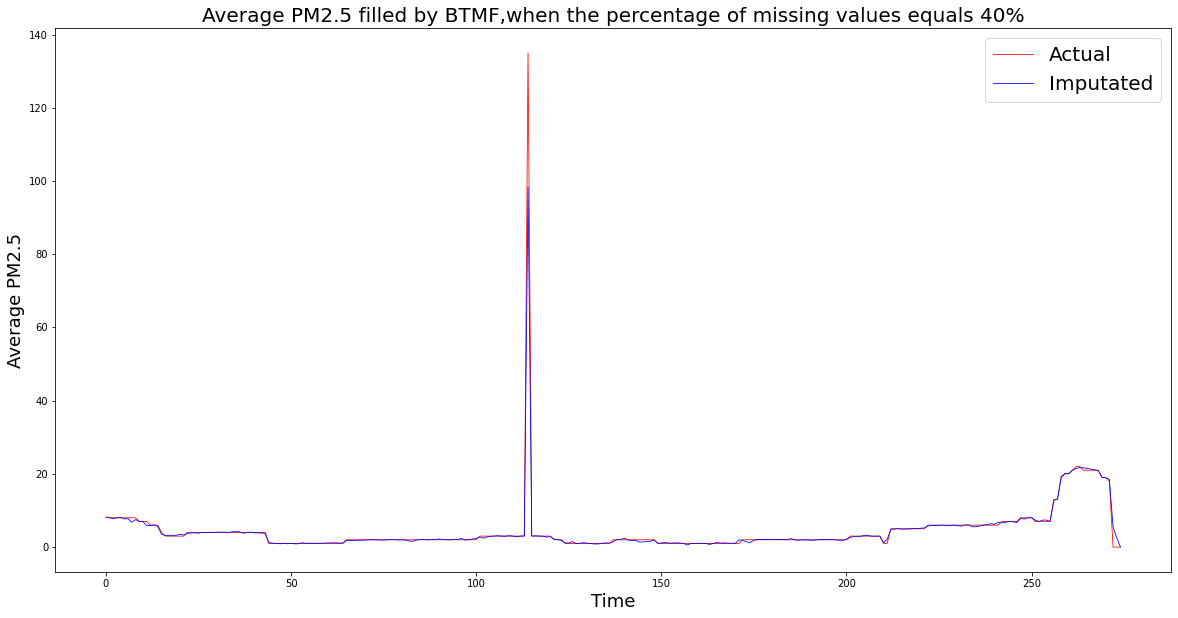

In [62]:
for idx in range(0, round(dense_mat.shape[0]/2)):
  plotTs(dense_mat[idx], mat_hat[idx], title='Average PM2.5 filled by BTMF,when the percentage of missing values equals 40%')

## Linear Interpolation

In [157]:
aux_arr = aux.to_numpy()
aux_incomplete =  np.copy(aux_arr)
missing_raw_values = np.random.uniform(0, 1, aux_arr.shape)
missing_mask = missing_raw_values < 0.3
missing_mask[0] = False
aux_incomplete[missing_mask] = np.nan

In [158]:
aux_incomplete = pd.DataFrame(aux_incomplete, columns = columnst, index= indext).reset_index()
aux_incomplete = aux_incomplete.copy(deep=True)
#aux_incomplete = aux_incomplete.T.drop(columns=['Date', 'Hour'])

In [159]:
LI = aux_incomplete.interpolate(method='linear')
LI = LI.set_index('Sensor')

In [164]:
LI = LI.T.reset_index().drop(columns=['Date', 'Hour'])

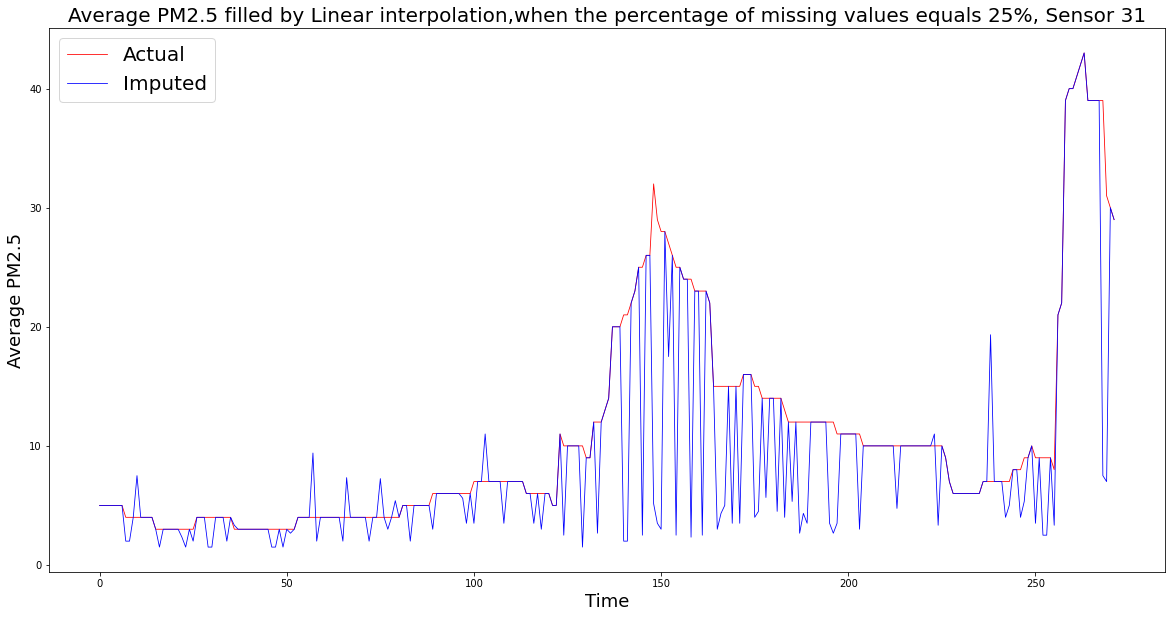

In [167]:
#sensor 31-33-34
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(aux.T['sensor31v2.csv'], 'r', label='Actual', linewidth=0.8)
plt.plot(LI['sensor31v2.csv'], 'b', label='Imputed', linewidth=0.8)
plt.title('Average PM2.5 filled by Linear interpolation,when the percentage of missing values equals 25%, Sensor 31', size=20)
#plt.title('Original average PM2.5 with a percentaje of missing values equals 25%, Sensor 31', size=20)
plt.xlabel('Time',size=18)
plt.ylabel('Average PM2.5',size=18)
#plt.legend(['Actual', 'Imputed'], fontsize=20)
plt.legend(fontsize=20)

As we can see the performance of linear interpolation is not the best.

## **Network implementation**

In this section the implementation of the network is made based on real information about the physical configuration of the sensor network, thanks to the adjacency matrix of the distances between sensors. On the other hand the analysis of the network behavior is made based on a simulated signal of the measurement of the sensors in differents instants in time

### Graph construction
In this section it is described how from real information about the location of the sensors a graph can be built

There is information on the distance between sensors, this is between 0 and 20 with this information we proceed to the construction of the final network. Taking into account that it is presented to reach a simple representation of the graph

In [ ]:
W = pd.read_csv('data/Pune_SensorLocationDistances.csv',header=0).set_index('0')
W.describe()

In [ ]:
Indices = [ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21,
            22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40,
            41, 42, 43, 45, 46, 48, 50, 51, 59]
W.columns = [int(x) for x in W.columns]
W= W.loc[Indices,Indices]
W.shape
len(Indices)

In [ ]:
fig = px.imshow(W)
fig.update_layout(
    title='Adjacent matrix')
fig.show()

The following chart shows the probability distribution function (PDF) and the cumulative distribution function (CDF) of the distances in order to analyze and choose the limit to establish the weight between connections. It is observed that the average value of the connections is between 5 and 7 and there are few connections greater than 17. If we take a threshold of 5 that is, connections greater than this value would be eliminated, 50% of the existing connections would be maintained, and we focus on the sensors that have a certain closeness in space.

In [ ]:
fig = go.Figure(data=[go.Histogram(x=W.to_numpy().flatten(),nbinsx=12,histnorm='probability density')])
fig.update_layout(title = "PDF Distances",xaxis_title="Distances")
fig.show()

fig = go.Figure(data=[go.Histogram(x=W.to_numpy().flatten(),nbinsx=12,histnorm='probability density',cumulative_enabled=True)])
fig.update_layout(title = "CDF Distances",xaxis_title="Distances")
fig.show()

To define the weight of an edge connecting two vertices is used the thresholded Gaussian kernel weighting function given by :


$ W_{i,j} = \left\{\begin{matrix}
exp(- \frac{\left | dist(i,j) \right |^{^2}}{2 \theta ^{2}}) &  dist(i,j) \leq k \\ 
0 & otherwise
\end{matrix}\right.$





In [ ]:
Theta, k = 4, 6 #Choosen values of k and theta
W_normal = Norm_W(W.copy(),Theta,k) 
A=W_normal.values

In [ ]:
fig = px.imshow(W_normal)
fig.update_layout(title='Adjacent matrix')
fig.show()

The following chart shows the probability distribution function (PDF) and the cumulative distribution function (CDF) of the weighted matrix. Most of the connections are between 0 and 0.4, i.e. they have a low weight.

In [ ]:
fig = go.Figure(data=[go.Histogram(x=W_normal.to_numpy().flatten(),nbinsx=12,histnorm='probability density')])
fig.update_layout(title = "PDF Distances",xaxis_title="Distances")
fig.show()

fig = go.Figure(data=[go.Histogram(x=W_normal.to_numpy().flatten(),nbinsx=12,histnorm='probability density',cumulative_enabled=True)])
fig.update_layout(title = "CDF Distances",xaxis_title="Distances")
fig.show()

The following graph shows the network with the original values of the adjacent matrix. 

In [ ]:
G = create_graph(W)
plot_graph(G)

In [ ]:
W_aux=W.copy()
column=W_aux.columns.to_list()
W_aux[column] = W_aux[column].where(~(W_aux[column]>10),other=0)

The following chart shows the W chart limiting the network connections

In [ ]:
G = create_graph(W_aux)
plot_graph(G)

A algotirm is applied to reduce the number of neighbors per vertex.

In [ ]:
A_neigh = Neighboors(A,5)
np.fill_diagonal(A_neigh, 0)

In the following graph the final network is presented taking into account the smoothing of the network.

In [ ]:
G = create_graph(A_neigh)
plot_graph(G)

In [ ]:
# Theta, k = 4, 6 #Choosen values of k and theta
# W_normal = Norm_W(W.copy(),Theta,k) 
A=A_neigh

In [ ]:
import networkx as nx
dt = [('len', float)]
A = A.view(dt)

G = nx.from_numpy_matrix(A)
pos = nx.spring_layout(G, k=0.5*1/np.sqrt(len(G.nodes())), iterations=50)
figure = pyplot.figure(figsize=(20, 10))
nx.draw(G,pos=nx.spring_layout(G,pos=pos),with_labels = True)
xyz = np.array([pos[v] for v in sorted(G)])

### Graph organization

In this section two methods are presented to reorganize the graph from the information given in the weight matrix

#### Spectral clusterin
This method makes use of the unsupervised spectral clustering algorithm in order to identify nodes that have close distances, and group them in the same set. This in order to obtain a reorganization of the network.
[Source](https://towardsdatascience.com/unsupervised-machine-learning-spectral-clustering-algorithm-implemented-from-scratch-in-python-205c87271045)

Initially Adjacency matrix W, Degree matrix D and the Laplacian matrix to obtain the eigenvalues and eigenvectors of the L matrix.

In [ ]:
import matplotlib
from pygsp import graphs

A_s=A_neigh
graph = graphs.Graph(A_s)
graph.set_coordinates(xyz)
graph.compute_fourier_basis()
e = graph.e
v = graph.U

In [ ]:
fig = plt.figure(figsize=[18, 6])
ax1 = plt.subplot(221)
plt.plot(e)
ax1.title.set_text('eigenvalues')

i = np.where(e < 20)[0]
ax2 = plt.subplot(222)
plt.plot(v[:, i[0]])
#ax2.title.set_text('first eigenvector with eigenvalue')
ax3 = plt.subplot(223)
plt.plot(v[:, i[1]])
ax3.title.set_text('second eigenvector with eigenvalue close to 0')
ax4 = plt.subplot(224)
plt.plot(v[:, i[2]])
ax4.title.set_text('third eigenvector with eigenvalue close to 0')
fig.tight_layout()

In [ ]:
def project_and_transpose(eigenvals, eigenvcts, num_ev):
    """Select the eigenvectors corresponding to the first 
    (sorted) num_ev eigenvalues as columns in a data frame.
    """
    eigenvals_sorted_indices = np.argsort(eigenvals)
    indices = eigenvals_sorted_indices[: num_ev]

    proj_df = pd.DataFrame(eigenvcts[:, indices.squeeze()])
    proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
    return proj_df

proj_df= project_and_transpose(e,v,10) #Taking the first 10 eigenvalues to make the analysis

The K-Means algorithm is applied and the inertia is calculated to choose the best possible number of clusters

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

inertias = []

k_candidates = range(1, 20)

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(proj_df)
    inertias.append(k_means.inertia_)

From the following graph K=10 is chosen because it has an inertia very close to 0

In [ ]:
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');

In [ ]:
def run_k_means(df, n_clusters):
    """K-means clustering."""
    k_means = KMeans(random_state=25, n_clusters=n_clusters)
    k_means.fit(df)
    cluster = k_means.predict(df)
    return cluster

def spectral_clustering(eigenvals, eigenvcts, n_clusters):
    """Spectral Clustering Algorithm."""
    proj_df = project_and_transpose(eigenvals, eigenvcts, n_clusters)
    cluster = run_k_means(proj_df, proj_df.columns.size)
    return cluster

The algorithm is executed for a number of clusters equal to 10

In [ ]:
Index_cluster= spectral_clustering(e,v,8)
index = np.argsort(Index_cluster)

In the following graph you can see the result of the clustering, where each color represents a different group. It is observed that most of the nodes that are physically close are grouped in the same set. This information is used to reorganize the graph.

In [ ]:
dt = [('len', float)]
A_s = A_s.view(dt)
G = nx.from_numpy_matrix(A_s)
pos = nx.spring_layout(G, k=0.5*1/np.sqrt(len(G.nodes())), iterations=50)
figure = pyplot.figure(figsize=(20, 10))
nx.draw(G,pos=nx.spring_layout(G,pos=pos),with_labels = True,node_color = Index_cluster, cmap = 'hsv')

In [ ]:
SortW = Sort=pd.DataFrame(data = A_neigh).iloc[index,index]
A_s=SortW.values
Grap_s=A_s

In [ ]:
fig = px.imshow(Grap_s)
fig.update_layout(
    title='Adjacent matrix')
fig.show()

In [ ]:
dt = [('len', float)]
A_s = A_s.view(dt)

G = nx.from_numpy_matrix(A_s)
pos = nx.spring_layout(G, k=0.5*1/np.sqrt(len(G.nodes())), iterations=50)
figure = pyplot.figure(figsize=(20, 10))
nx.draw(G,pos=nx.spring_layout(G,pos=pos),with_labels = True)
xyz = np.array([pos[v] for v in sorted(G)])

#### Bandwidth Reduction

The reverse Cuthill–McKee algorithm is an algorithm to permute a sparse matrix that has a symmetric sparsity pattern into a band matrix form with a small bandwidth.

In [ ]:
Theta, k = 4, 6
W_normal = Norm_W(W.copy(),Theta,k) 
A=W_normal.values
A_neigh = Neighboors(A,5)
np.fill_diagonal(A_neigh, 0)

In [ ]:
#Function
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee


def ReOrderGraph(A):
    csrMatrix = csr_matrix(A)
    perm = reverse_cuthill_mckee(csrMatrix)
    A_reorder = csrMatrix[perm, :][:, perm].toarray()
    return A_reorder,perm

def Graph_Nodes(A):
    dt = [('len', float)]
    A = A.view(dt)
    G = nx.from_numpy_matrix(A)
    pos = nx.spring_layout(G, k=0.5*1/np.sqrt(len(G.nodes())), iterations=50)
    figure = pyplot.figure(figsize=(20, 10))
    nx.draw(G,pos=nx.spring_layout(G,pos=pos),with_labels = True)
    xyz = np.array([pos[v] for v in sorted(G)])
    return xyz

In order to apply the algorithm, the "Scipy" library is used, which returns the permutation array that orders a sparse CSR or CSC matrix in Reverse-Cuthill McKee ordering. [source 2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.reverse_cuthill_mckee.html)

In [ ]:
A_reorder,perm = ReOrderGraph(A_neigh)
xyz = Graph_Nodes(A_reorder)

In [ ]:
fig = px.imshow(A_reorder)
fig.update_layout(
    title='Adjacent matrix')
fig.show()

In [ ]:
graph = graphs.Graph(A_reorder)
graph.set_coordinates(xyz)
graph.compute_fourier_basis()
plot_graph(graph)

It is observed that with both methods a similar result is obtained, however due to simplicity the Cuthill-McKee band reduction method is chosen

In [ ]:
graph = graphs.Graph(A_reorder)
graph.set_coordinates(xyz)
graph.compute_fourier_basis()

## **Simulated Drift Implementation**


In this section We will define sinusoidal signals for all the nodes of the network to be analyzed, presenting in the vertex 0 a drift behavior from a certain instant of time. We will then analyze different characteristics of the network using the Graph Fourier Transform (GFT).

In [ ]:
matplotlib.rcParams["image.cmap"] = 'viridis'

# Constants
SPACE_GRAPH_ORDER, SPACE_KERNEL_SCALE = graph.N, 1 
TIME_GRAPH_ORDER, TIME_KERNEL_SCALE = 50, 10
dT = 10.0/TIME_GRAPH_ORDER # Time sample
LEVEL_NOISE, BREAK_TIME, STD = 0.3, 20, 3 # LN, brownian Motion (BM) start-point and SD in BM
VERTEX_D = 4 # Drift vertex

### Network in time and space

In the following graph, the two graphs to be analyzed are presented. On the one hand, we have the network of sensors obtained in the previous session, and on the other, we have a path graph which represents the time, in this case 50 different moments. Small groups of nodes are made, in order to simulate similar segmented behavior in the network


In [ ]:
# Space-time graph definition
groups = np.array([0]*21 + [1]*22)
space_time_graph = [graph, create_path_graph(TIME_GRAPH_ORDER)]

plot_graph(space_time_graph[0],groups)
plot_graph(space_time_graph[1])

In [ ]:
kernel_anima(space_time_graph, (SPACE_GRAPH_ORDER//2,TIME_GRAPH_ORDER//2), 
             windows_kernels = [SPACE_KERNEL_SCALE, TIME_KERNEL_SCALE])

### Signal definition
Now we create a function that defines the signal to be implemented on the space network, based on different space/time eigenvalues.

Let's see how each signal looks in all the vertex.

In [ ]:
sgroups = np.array([5]*21 + [34]*22)
tgroups = [6]*(TIME_GRAPH_ORDER//3) + [20]*(TIME_GRAPH_ORDER//3) + [38]*(TIME_GRAPH_ORDER - 2*(TIME_GRAPH_ORDER//3))

space_time_graph = [graph, create_path_graph(TIME_GRAPH_ORDER)]
time_series = time_space_signal_gen(space_time_graph, sgroups, tgroups, ln = LEVEL_NOISE, normalize = True)
brownian(time_series[VERTEX_D,BREAK_TIME - 1], TIME_GRAPH_ORDER - BREAK_TIME, dT, STD, out = time_series[VERTEX_D,BREAK_TIME:])

In [ ]:
import plotly.graph_objects as go
# Create traces
fig = go.Figure()
for i in range(len(time_series)):
    fig.add_trace(go.Scatter(x=list(range(len(time_series[i]))), 
                             y=time_series[i], mode='lines', name='Node'+str(i)))

fig.update_layout(
    title="Experimental signals",
    xaxis_title="Time",
    yaxis_title="Signal value")

fig.show()

The next graph shows the signal inside the space-time graph in a given time. For example, at time instant 3, it is observed that the network is divided into two sections because the signal strength is inverse for the groups created, that is, one group of nodes has a high value while the other has a low.

In [ ]:
signal_graph_anima(space_time_graph, time_series)

### GFT in time and space

In this section we present functions to calculate the graph fourier transform in time and space

To check that the desired signal was processed correctly, the signal on a particular node and its Graph Fourier Transform (GFT) can be displayed with the following code section. 

In [ ]:
gft_signal_anima(space_time_graph[1], time_series, is_graph_space = False)

From the graph above it can be seen that the signal at node 0 (where the drift occurs) most of its energy is concentrated in the low frequencies, in other words in the eigenvalues close to 0. For the other nodes, there are higher frequencies, being these on the seventh eigenvalue.

This behavior is explained having in mind that after the drift, the signal in the 0 vertex presents a constant decrease, while in the rest of sensors the sinusoidal signal continues its periosity. 

In [ ]:
gft_signal_anima(space_time_graph[0], time_series, is_graph_space = True)

From the graph above, it is observed that in general, the frequency components in time are found in greater magnitude at low levels, however they present in higher frequencies, because the signal in a moment of time varies in the network in general. After the drift in certain instants, it is observed greater power in high frequencies / eigenvalues

### Spectrogram for disjoint GFT

To have a more detailed understanding, we will first analyze the graphs separately. The following function allows to display the spectrogram of each network by selecting a specific time (for the spatial graph) or a specific vertex (for the temporal graph), depending on the case.

In [ ]:
spectogram_anima(space_time_graph[0], time_series, SKS = SPACE_KERNEL_SCALE, 
                 is_graph_space = True, limits = [0.0, 0.5], lamdba_lim = None)

In [ ]:
spectogram_anima(space_time_graph[1], time_series, SKS = TIME_KERNEL_SCALE, 
                 is_graph_space = False, limits = None, lamdba_lim = None)

* **Spatial-graph:** It is important to consider that the same signal is passed through a certain group of vertices $s(v,t_{i})$. It is observed that before the drift there is high power at low frequency in these vertices, after the drift higher frequency components are observed with high power values, corresponding in turn to the "group".

* **Time-graph:** Focusing on the signal from only one particular node $s(v_{i},t)$, it is easy to determine which vertex is faulty, since the respective spectrogram differs greatly from the other vertices, even though the signal of all should be the same. For the vertex 0, it is observed that before the drift (instant 20) the frequency component is high and after it is reduced to eigenvalues close to zero, behavior that is explained because after the drift the signal decreases progressively 

### Spectrogram for joint GFT (JFT)
Now we will enter to observe the properties of the space-time joint spectrogram. This is possible thanks to the following function. Since the joint spectrogram is in principle a two-dimensional array for each possible combination in space and time, we have as a result an array in $\mathbb{R}^4$, being useful to indicate a specific vertex and instant, looking for interpretability.

In [ ]:
kernels, joint_spectogram = JFT_anima(space_time_graph, time_series, [SPACE_KERNEL_SCALE, TIME_KERNEL_SCALE],
                                     lspace_lim = None, ltime_lim = None)

Taking into account that the joint spectrogram estimates different spectrograms, each of them centered on the combination ($v_i$, $t_j$), the analysis of the results should be done for each possible combination, arriving at the following statements:

1.  As explained above, the process occurs at "low frequencies" for any possible event, in time, which directly affects the joint spectrogram, being only possible to see non-zero magnitudes in the upper left region (low orders of eigenvalues in time).
2.  The signal $s(v_i,t)$ has more frequency components compared to the signal $s(v,t_i)$, being possible to observe in the spectrogram for any combination. 


### Drift detection

In order to detect the drift concept, we will use one technique to detect outliers. For this, we will perform the subtraction of sub-spectrograms centered on the pair $(v_i, t_j)$ and plot the result, trying to find the most changing sub-spectrogram.

In [ ]:
SPACE_WINDOW, TIME_WINDOW = 0, 2
filename = './data/drift_joint_sim.csv'

In [ ]:
dist_matrix = plot_dist_matrix(joint_spectogram.copy(), SPACE_WINDOW, TIME_WINDOW, filename = filename, 
                               norm_each_sg = False, overwrite = False,)

In [ ]:
dist_matrix = plot_dist_matrix(joint_spectogram.copy(), SPACE_WINDOW, TIME_WINDOW, filename = filename, 
                               norm_each_sg = False, overwrite = False,
                               vlist = range(VERTEX_D-1,VERTEX_D+2),)

## **Real signal analysis**

By observing a first view of the behavior of a signal that presents drift in one of its nodes, in order to understand its spectral representation, we can begin to analyze the signals captured by the sensor network. To do this, we must take a reading of the gas to be analyzed: PM, which is a measure of how polluted the air is at a location. We will then build a matrix containing the signal from each sensor per hour, from August 28 to October 28, 2019.

### Data read
Let's start with the reading of the signals, contained in the directory `air-polution-sensor/data/sensorv2/`.

In [ ]:
def readFileList(file_directory, ext = 'csv'): # Read a valid json-files inside folder / independenly file
    files_list = []
    if os.path.isdir(file_directory): # Return files with 'json' extension
        for root_path, _, files_name in os.walk(file_directory):
            files_list += [os.path.join(root_path, x) for x in files_name if x.split(".")[-1].lower() == ext.lower()]
    elif file_directory.split('.')[-1] == ext: files_list = [file_directory] # Return file inside of list
    return files_list

def sensor_read_signal(signal_name = "PM2_AVG"): # Read all signals and join in one matrix
    signals_list = readFileList("./data/data_filled")
    signals = None
    for signal_file in signals_list:
        new_col_name = os.path.split(signal_file)[-1].replace("v2.csv","").replace("sensor","")
        new_col_name = int(new_col_name) # Only keep sensor id
        sig = pd.read_csv(signal_file).rename(columns = {signal_name: new_col_name}) # Read signal
        sig["Date"] = pd.to_datetime(sig["Date"] + " " + sig["Hour"].astype(str) + ":00:00")
        sig.set_index("Date", inplace = True)
        sig=sig.loc['2019-10-01':'2019-10-03'] #For drift
        #sig=sig.loc['2019-10-01':'2019-12-30']
        # Merge by date
        if signals is None: signals = sig[[new_col_name]].copy()
        else: signals = signals.merge(sig[[new_col_name]], copy = False, left_index = True, right_index = True)
    signals = signals.sort_index().T
    
    # Fill empty sensors with NaN values
    #start, end = signals.index.min(), signals.index.max() # Find empty frames and fill in
    # start, end = 1,50
    # empty_sensors = sorted(set(range(start, end + 1)).difference(signals.index.values))
    # if len(empty_sensors) > 0: 
    #     signals = signals.reindex(signals.index.to_list() + empty_sensors).fillna(0.0) # Comment fillna(0.0) to return NaN values
    print(signals.index.sort_values())
    return signals.sort_index().values # Comment .values to return dataframe

time_sensors_series = sensor_read_signal()
print(time_sensors_series.shape)
#time_sensors_series#.head(30)

In [ ]:
sig = pd.read_csv("./data/data_filled/sensor13v2.csv").rename(columns = {"PM2_AVG": 1}) # Read signal
sig["Date"] = pd.to_datetime(sig["Date"] + " " + sig["Hour"].astype(str) + ":00:00")
sig["Day"] = sig["Date"].dt.date
sig["date_2"] = sig["Date"]
sig.set_index("Date", inplace = True)

In [ ]:
sig=sig.loc['2019-10-01':'2019-10-03']
fig = px.line(sig, x="date_2", y=1)
fig.show()

In [ ]:
matplotlib.rcParams["image.cmap"] = 'viridis'

# Constants
SPACE_GRAPH_ORDER, SPACE_KERNEL_SCALE = graph.N, 3 #40, 3
TIME_GRAPH_ORDER, TIME_KERNEL_SCALE = time_sensors_series.shape[1], 3

In [ ]:
space_time_graph = [graph, create_path_graph(TIME_GRAPH_ORDER)]

In [ ]:
perm

In [ ]:
time_sensors_series=time_sensors_series[perm]

In [ ]:
t = np.linspace(0, TIME_GRAPH_ORDER*dT, TIME_GRAPH_ORDER)
t = np.ones((SPACE_GRAPH_ORDER,1))*t[None]
# plot_curves(t, time_sensors_series, xlabel = "time", ylabel = "Vertex-magnitud")

In [ ]:
import plotly.graph_objects as go
# Create traces
fig = go.Figure()
for i in range(len(time_sensors_series)):
  fig.add_trace(go.Scatter(x=t[i], y=time_sensors_series[i],
                    mode='lines',
                    name='Node'+str(i)))

fig.update_layout(
    title="Study window",
    xaxis_title="Time instant",
    yaxis_title="PM 2"

)

fig.show()

In [ ]:
space_time_graph[1].N

In [ ]:
signal_graph_anima(space_time_graph, time_sensors_series)

In [ ]:
gft_signal_anima(space_time_graph[1], time_sensors_series, is_graph_space = True, x_lim = [0,50])

In [ ]:
gft_signal_anima(space_time_graph[0], time_sensors_series, is_graph_space = False)

### DFT analysis

#### Spatial-graph spectogram

In [ ]:
spectogram_anima(space_time_graph[0], time_sensors_series, SKS = SPACE_KERNEL_SCALE, is_graph_space = True, 
                 limits = [0.0, 3000])

#### Time-graph spectrogram

In [ ]:
spectogram_anima(space_time_graph[1], time_sensors_series, SKS = TIME_KERNEL_SCALE, is_graph_space = False, 
                 limits = None, lamdba_lim = [0,500])

In [ ]:
kernels, joint_spectogram = JFT_anima(space_time_graph, time_sensors_series, [SPACE_KERNEL_SCALE, TIME_KERNEL_SCALE],
                                     lspace_lim = None, ltime_lim = None)

### Drift detection

In [ ]:
SPACE_WINDOW, TIME_WINDOW = 1, 10
filename = './data/drift_joint_real.csv'

In [ ]:
plot_norm_matrix(joint_spectogram, SPACE_WINDOW, TIME_WINDOW)

In [ ]:
# dist_matrix = plot_dist_matrix(joint_spectogram.copy(), SPACE_WINDOW, TIME_WINDOW, filename = filename, overwrite = False,
#                                xlim = [170,270], ylim = [170,270],) #image_save = './dist_real.png',)
# dist_matrix.columns[170:270]
# dist_matrix.columns[170:270]

## ***Anexos: GitHub-Colab connection***
Here, some commands to upload/save the github respository

In [ ]:
''' Function definitions'''
# Git pull
def git_pull(repo_pwd, show_current_branch = False, make_commit = False): # Only for colab space work
    global user_git, email_git
    import sys
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        from google.colab import drive
        drive.mount('/content/gdrive')

        %cd "$repo_pwd"
        # !git config --list
        if show_current_branch: 
            !git branch 
        if make_commit:
            if "user_git" not in globals(): user_git = input("User github?: ")
            if "email_git" not in globals(): email_git = input("Email github?: ") 
            !git config --global user.email $email_git
            !git config --global user.name $user_git
            !git commit -am "Updating in colab"
        !git pull
        !git status
    else:
        print("[INFO] You are not in collaboration, nothing has been done.")

# Git push
def git_push(repo_pwd): # Only for colab space work
    global user_git, email_git
    import sys
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        from google.colab import drive
        import getpass
        drive.mount('/content/gdrive')

        %cd "$repo_pwd"
        if "user_git" not in globals(): user_git = input("User github?: ")
        if "email_git" not in globals(): email_git = input("Email github?: ")

        # Password login
        try: 
            pwd_git = getpass.getpass(prompt='{} github password: '.format(user_git)) 
        except Exception as error: 
            print('ERROR', error) 

        # Upload from every where
        origin_git = !git config --get remote.origin.url
        origin_git = origin_git[0].replace("https://","https://{}:{}@".format(user_git,pwd_git))

        !git config --global user.email "$email_git"
        !git config --global user.name "$user_git"
        !git status

        x = " "
        while x.lower() != "y" and x.lower() != "n": x = input("Continue?...[y/n]: ")

        if x.lower() == "y":
            com_message = input("Enter the commit message: ")
            !git add .
            !git commit -am "$com_message"
            !git push "$origin"
            !git status
    else:
        print("[INFO] You are not in collaboration, nothing has been done.")

In order to execute the functions, please unlock the respective function

In [ ]:
# git_pull(repo_pwd, show_current_branch = False, make_commit = True)
# git_push(repo_pwd)